MMI

In [1]:
import sys, os, importlib.util
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

from scipy.constants import lambda2nu, nu2lambda, c
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

In [3]:
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

modeApi = lumapi.MODE(hide = False)

In [4]:
um = 1e-6
nm = 1e-9

In [5]:
n_c = 1.444
n_r = 3.476
lmbd = 1550*nm
W_m = 10*um
k_0 = 2*np.pi/lmbd
N = 4
m = N+1

In [6]:
sigma = 0
We = W_m + (lmbd / np.pi) * ((n_c / n_r)**(2 * sigma)) * (n_r**2 - n_c**2)**(-0.5)
We/um

10.156040531990453

In [7]:
neffapx = np.zeros(5)
for i in range(5):
    neffapx[i] = n_r - ((i+1)**2*np.pi*lmbd)/(We**2*4*n_r*k_0)
    kc = (i+1)*np.pi/We

In [8]:
L_pi = 2*np.pi/(neffapx[0]-neffapx[2])*1/k_0 
print(f'L\u03C0 = {L_pi/um:.2f}\u03BCm')

Lπ = 231.31μm


In [9]:
L = 3/N*L_pi
print(f'Comprimento da caixa central = {L/um:.2f}\u03BCm')

Comprimento da caixa central = 173.48μm


In [10]:
altura = 220*nm
espessura = 480*nm
comprimento = 2*um

comprimento_taper = 6*um
espessura_taper = 2*um

espassamento = 0.5*um

espessura_sub = 25*um
altura_sub = 2*um
comprimento_sub = (L + comprimento_taper*2 + comprimento*2) + 10*um

In [11]:
material_waveguide = 'Si (Silicon) - Palik'
material_background = 'SiO2 (Glass) - Palik'

In [12]:
x_MMI = 0
y_MMI = 0
z_MMI = 0

x_substract = 0
y_substract = 0
z_substract = -altura/2- altura_sub/2

x_taper = L/2 + comprimento_taper/2
y_taper = (espassamento + espessura_taper)/2
z_taper = z_MMI

x_waveguide =  L/2 + comprimento_taper + comprimento/2
y_waveguide = y_taper
z_waveguide = z_taper

x_EME_span = L + comprimento_taper*2 + comprimento*2
x_EME = x_EME_span/2 - 0.5*um
port_span = 2*um

In [13]:
lmbd_start = 1.530*um
lmbd_stop = 1.570*um
numberpoint = 25

In [14]:
modeApi.switchtolayout()

modeApi.select('GDS_LAYER_35:4')
modeApi.delete()

modeApi.addstructuregroup()
dev_layer = 'GDS_LAYER_35:4'
modeApi.set('name', dev_layer)
modeApi.set('x', x_MMI)
modeApi.set('y', y_MMI)
modeApi.set('z', z_MMI)

In [15]:
modeApi.switchtolayout()

modeApi.select(f'{dev_layer}::Substract')
modeApi.delete()

modeApi.addrect()
modeApi.addtogroup(dev_layer)
modeApi.set('name', 'Substract')
modeApi.set('x span', comprimento_sub)
modeApi.set('y span', espessura_sub)
modeApi.set('z span', altura_sub)
modeApi.set('x', x_substract)
modeApi.set('y', y_substract)
modeApi.set('z', z_substract)
modeApi.set('material', material_background)

modeApi.select(f'{dev_layer}::Box')
modeApi.delete()

modeApi.addrect()
modeApi.addtogroup(dev_layer)
modeApi.set('name', 'Box')
modeApi.set('x span', L)
modeApi.set('y span', W_m)
modeApi.set('z span', altura)
modeApi.set('x', x_MMI)
modeApi.set('y', y_MMI)
modeApi.set('z', z_MMI)
modeApi.set('material', material_waveguide)

In [16]:
modeApi.switchtolayout()

for i in range(1,9):
    taper_name = f'Taper_{i}'
    modeApi.select(taper_name)
    modeApi.delete()
    modeApi.addobject('linear_taper')
    modeApi.addtogroup(dev_layer)
    modeApi.set('name', taper_name)
    modeApi.set('angle_side', 90)
    modeApi.set('thickness', altura)
    modeApi.set("len", comprimento_taper)
    modeApi.set("material", material_waveguide)
    modeApi.set("z", z_taper)
    if i<=4:
        modeApi.set("width_l", espessura)
        modeApi.set("width_r", espessura_taper)
        modeApi.set('x', -x_taper)
        if i==1 or i==4:
            modeApi.set('y', -(-1)**i*y_taper*3)
        else:
            modeApi.set('y', (-1)**i*y_taper)
    else:
        modeApi.set("width_l", espessura_taper)
        modeApi.set("width_r", espessura)
        modeApi.set('x', x_taper)
        if i==5 or i==8:
            modeApi.set('y', -(-1)**i*y_taper*3)
        else:
            modeApi.set('y', (-1)**i*y_taper)

In [17]:
modeApi.switchtolayout()

for i in range(1,9):
    waveguide_name = f'Waveguide_{i}'
    modeApi.select(waveguide_name)
    modeApi.delete()
    modeApi.addrect()
    modeApi.addtogroup(dev_layer)
    modeApi.set('name', waveguide_name)
    modeApi.set('x span', comprimento)
    modeApi.set('y span', espessura)
    modeApi.set('z span', altura)
    modeApi.set('z', z_waveguide)
    modeApi.set('material', material_waveguide)
    if i<=4:
        modeApi.set('x', -x_waveguide)
        if i==1 or i==4:
            modeApi.set('y', -(-1)**i*y_waveguide*3)
        else:
            modeApi.set('y', (-1)**i*y_waveguide)
    else:
        modeApi.set('x', x_waveguide)
        if i==5 or i==8:
            modeApi.set('y', -(-1)**i*y_waveguide*3)
        else:
            modeApi.set('y', (-1)**i*y_waveguide)

In [18]:
modeApi.switchtolayout()

modeApi.select('EME')
modeApi.delete()

modeApi.addeme()

modeApi.set('x',0)
modeApi.set("x min", -x_EME)
modeApi.set('y',0)
modeApi.set('z',0)
modeApi.set('y span', W_m*2)
modeApi.set('z span', altura*10)

modeApi.set("background material", '<Object defined dielectric>')
modeApi.set("index", '1')


In [19]:
modeApi.switchtolayout()

cell_waveguide = 1
cell_taper = 12
cell_box = 1

span_waveguide = comprimento - 0.5*um
span_taper = comprimento_taper
span_box = L

method_waveguide = 0
method_taper = 1
method_box = 0


modes_waveguide = 10
modes_taper = 26
modes_box = 49

modeApi.set("number of cell groups", 5)
modeApi.set("group spans", np.block([[span_waveguide], [span_taper], [span_box], [span_taper], [span_waveguide]]))
modeApi.set("cells", np.block([[cell_waveguide], [cell_taper], [cell_box], [cell_taper], [cell_waveguide]]))
modeApi.set("subcell method", np.block([[method_waveguide], [method_taper], [method_box], [method_taper], [method_waveguide]]))
modeApi.set("allow custom eigensolver settings", True)
modeApi.set("modes", np.block([[modes_waveguide], [modes_taper], [modes_box], [modes_taper], [modes_waveguide]]))
modeApi.set("display cells", 1)

modeApi.set("mesh cells y", 100)
modeApi.set("mesh cells z", 100)

modeApi.set("y min bc", "PML")
modeApi.set("y max bc", "PML")
modeApi.set("z min bc", "PML")
modeApi.set("z max bc", "PML")


In [20]:
modeApi.switchtolayout()

for i in range(1,9):
    port_name = f'EME::Ports::port_{i}'
    modeApi.select(port_name)
    modeApi.delete()
    modeApi.addemeport()
    modeApi.select(port_name)
    modeApi.set("use full simulation span", 0)
    modeApi.set("z", 0)
    modeApi.set('y span', port_span)
    modeApi.set('z span', port_span)
    modeApi.set("mode selection", "fundamental TE mode")
    if i<=4:
        modeApi.set("port location", "left")
        if 2<=i<=3:
            modeApi.set("y", ((-1)**i)*y_taper)
        else:
            modeApi.set("y", (-(-1)**i)*y_taper*3)
    else:
        modeApi.set("port location", "right")
        if 6<=i<=7:
            modeApi.set("y", ((-1)**i)*y_taper)
        else:
            modeApi.set("y", (-(-1)**i)*y_taper*3)

In [21]:
modeApi.switchtolayout()

modeApi.select("Monitor")
modeApi.delete()
modeApi.addemeprofile()
modeApi.set("name", "Monitor")
modeApi.set("monitor type", 3)
modeApi.set("x", 0)
modeApi.set("x span", x_EME_span)
modeApi.set("y", 0)
modeApi.set("y span", W_m*1.5)
modeApi.set("z", 0)


In [22]:
modeApi.switchtolayout()

modeApi.select('mesh_box')
modeApi.delete()

modeApi.addmesh()
modeApi.set('name','mesh_box')
modeApi.set('based on a structure', True)
modeApi.set('structure', 'Box')

modeApi.set('set mesh multiplier', True)
modeApi.set("x mesh multiplier", 4)
modeApi.set("y mesh multiplier", 4)
modeApi.set("z mesh multiplier", 4)

for i in range(1,9):
    mesh_name = f'mesh_port_{i}'
    port_name = f'Taper_{i}'
    modeApi.select(mesh_name)
    modeApi.delete()
    modeApi.addmesh()
    modeApi.set('name', mesh_name)
    modeApi.set('set mesh multiplier', True)
    modeApi.set("x mesh multiplier", 10)
    modeApi.set("y mesh multiplier", 10)
    modeApi.set("z mesh multiplier", 10)
    modeApi.set('based on a structure', True)
    modeApi.set('structure', port_name)

In [23]:
modeApi.save('MMI_SIMULACAO - EME')

In [24]:
modeApi.run()

In [25]:
modeApi.setemeanalysis('Mode convergence sweep', 1)
modeApi.setemeanalysis('start mode', 1)
modeApi.setemeanalysis('mode interval', 1)

In [26]:
modeApi.emesweep('mode convergence sweep')
S = modeApi.getemesweep('S_mode_convergence_sweep')
Modes = S['modes']

T1 = np.abs(S['s11'])**2
T5 = np.abs(S['s51'])**2
T6 = np.abs(S['s61'])**2
T7 = np.abs(S['s71'])**2
T8 = np.abs(S['s81'])**2

T1_dB = 10*np.log10(T1)
T5_dB = 10*np.log10(T5)
T6_dB = 10*np.log10(T6)
T7_dB = 10*np.log10(T7)
T8_dB = 10*np.log10(T8)

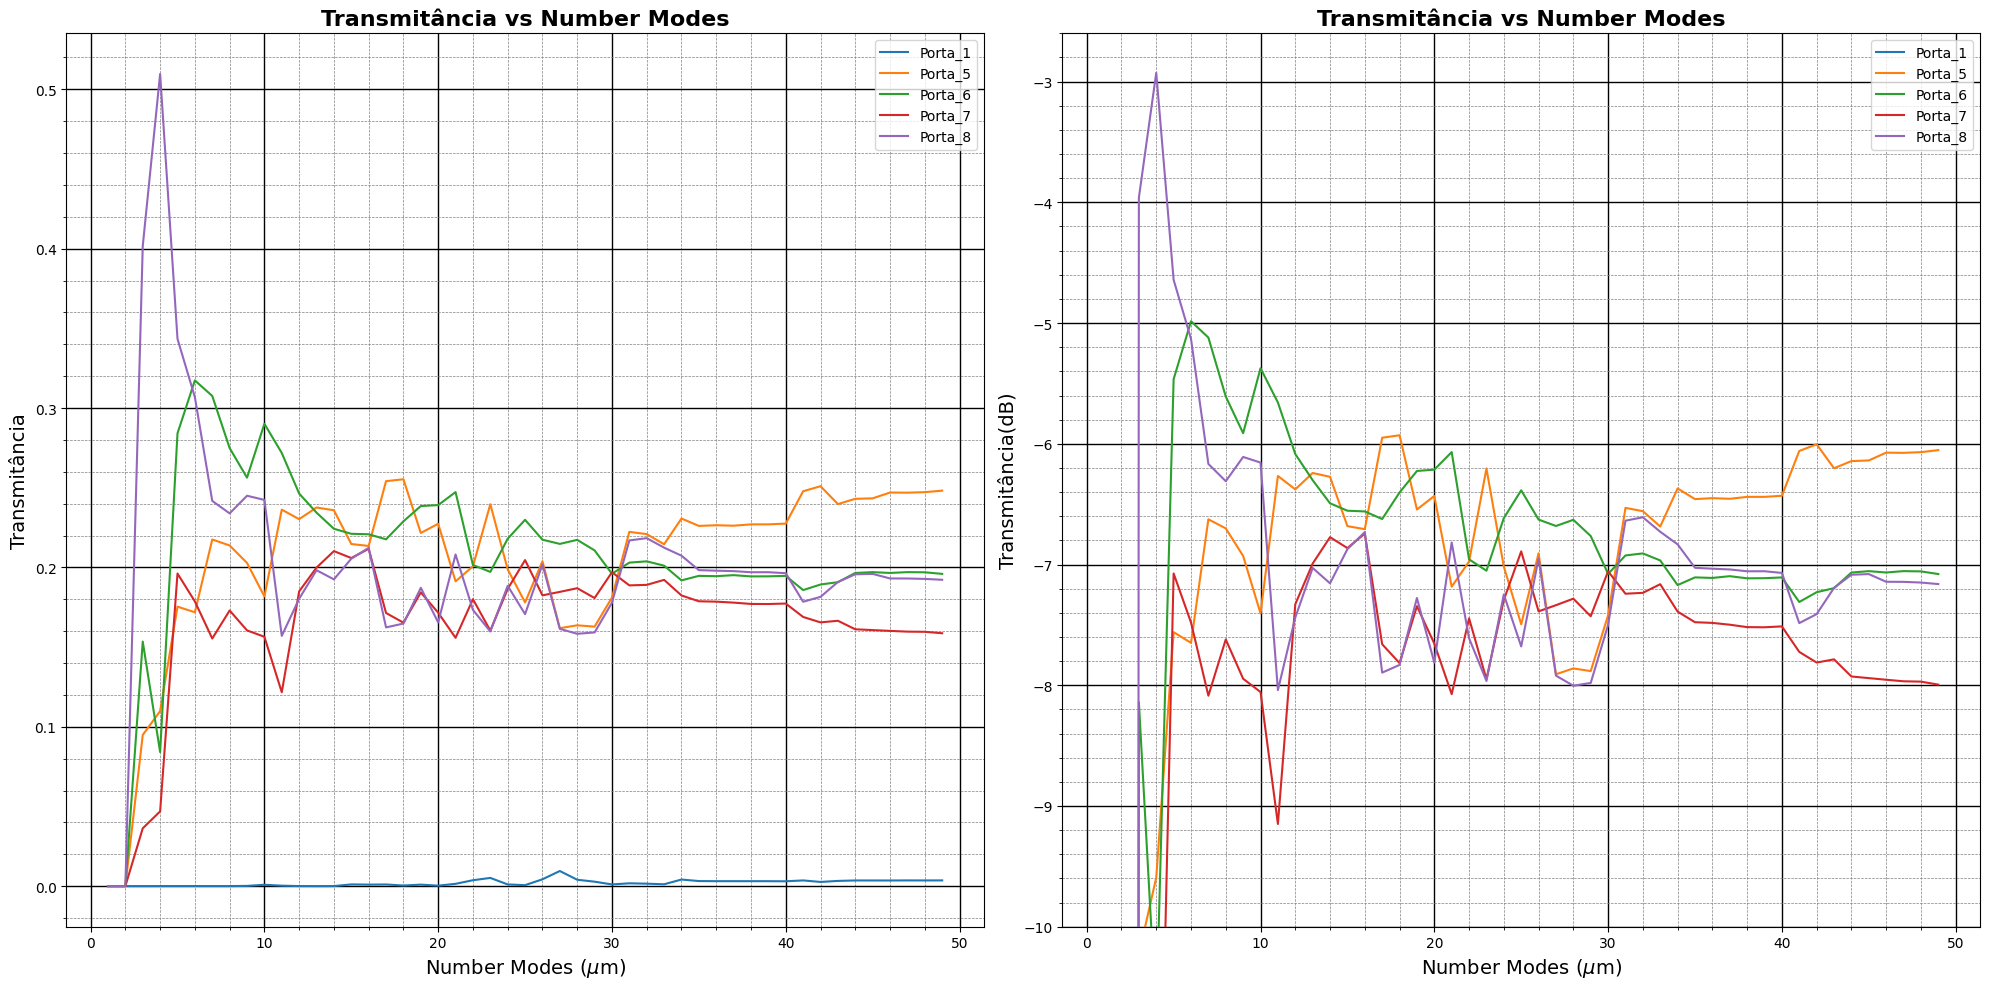

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(Modes, T1, lw=1.5, label='Porta_1')
axs[0].plot(Modes, T5, lw=1.5, label='Porta_5')
axs[0].plot(Modes, T6, lw=1.5, label='Porta_6')
axs[0].plot(Modes, T7, lw=1.5, label='Porta_7')
axs[0].plot(Modes, T8, lw=1.5, label='Porta_8')
axs[0].set_xlabel(r'Number Modes ($\mu$m)', fontsize=14)
axs[0].set_ylabel('Transmitância', fontsize=14)
axs[0].set_title(r'Transmitância vs Number Modes', fontsize=16, fontweight = 'bold',)
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].legend()

axs[1].plot(Modes, T1_dB, lw=1.5, label='Porta_1')
axs[1].plot(Modes, T5_dB, lw=1.5, label='Porta_5')
axs[1].plot(Modes, T6_dB, lw=1.5, label='Porta_6')
axs[1].plot(Modes, T7_dB, lw=1.5, label='Porta_7')
axs[1].plot(Modes, T8_dB, lw=1.5, label='Porta_8')
axs[1].set_xlabel(r'Number Modes ($\mu$m)', fontsize=14)
axs[1].set_ylabel('Transmitância(dB)', fontsize=14)
axs[1].set_title(r'Transmitância vs Number Modes', fontsize=16, fontweight = 'bold',)
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].legend()
axs[1].set_ylim([-10,-2.6])

plt.tight_layout()
plt.savefig('Transmissao_nas_portas_EME_Modes.png')
plt.show()

In [28]:
modeApi.emepropagate()

In [29]:
E = modeApi.getresult('Monitor', 'field profile')

x = E['x']
x = x[:,0]/um

y = E['y']
y = y[:,0]/um

z = E['z']
E = E['E']

Ex = E[:,:,0,:,0]
Ey = E[:,:,0,:,1]
Ez = E[:,:,0,:,2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + Ez**2)
Emag_log = 10*np.log10((Emag[:,:,0]))

C:\Users\edilb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
C:\Users\edilb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
C:\Users\edilb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\contour.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg, np.float64)
C:\Users\edilb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\cor

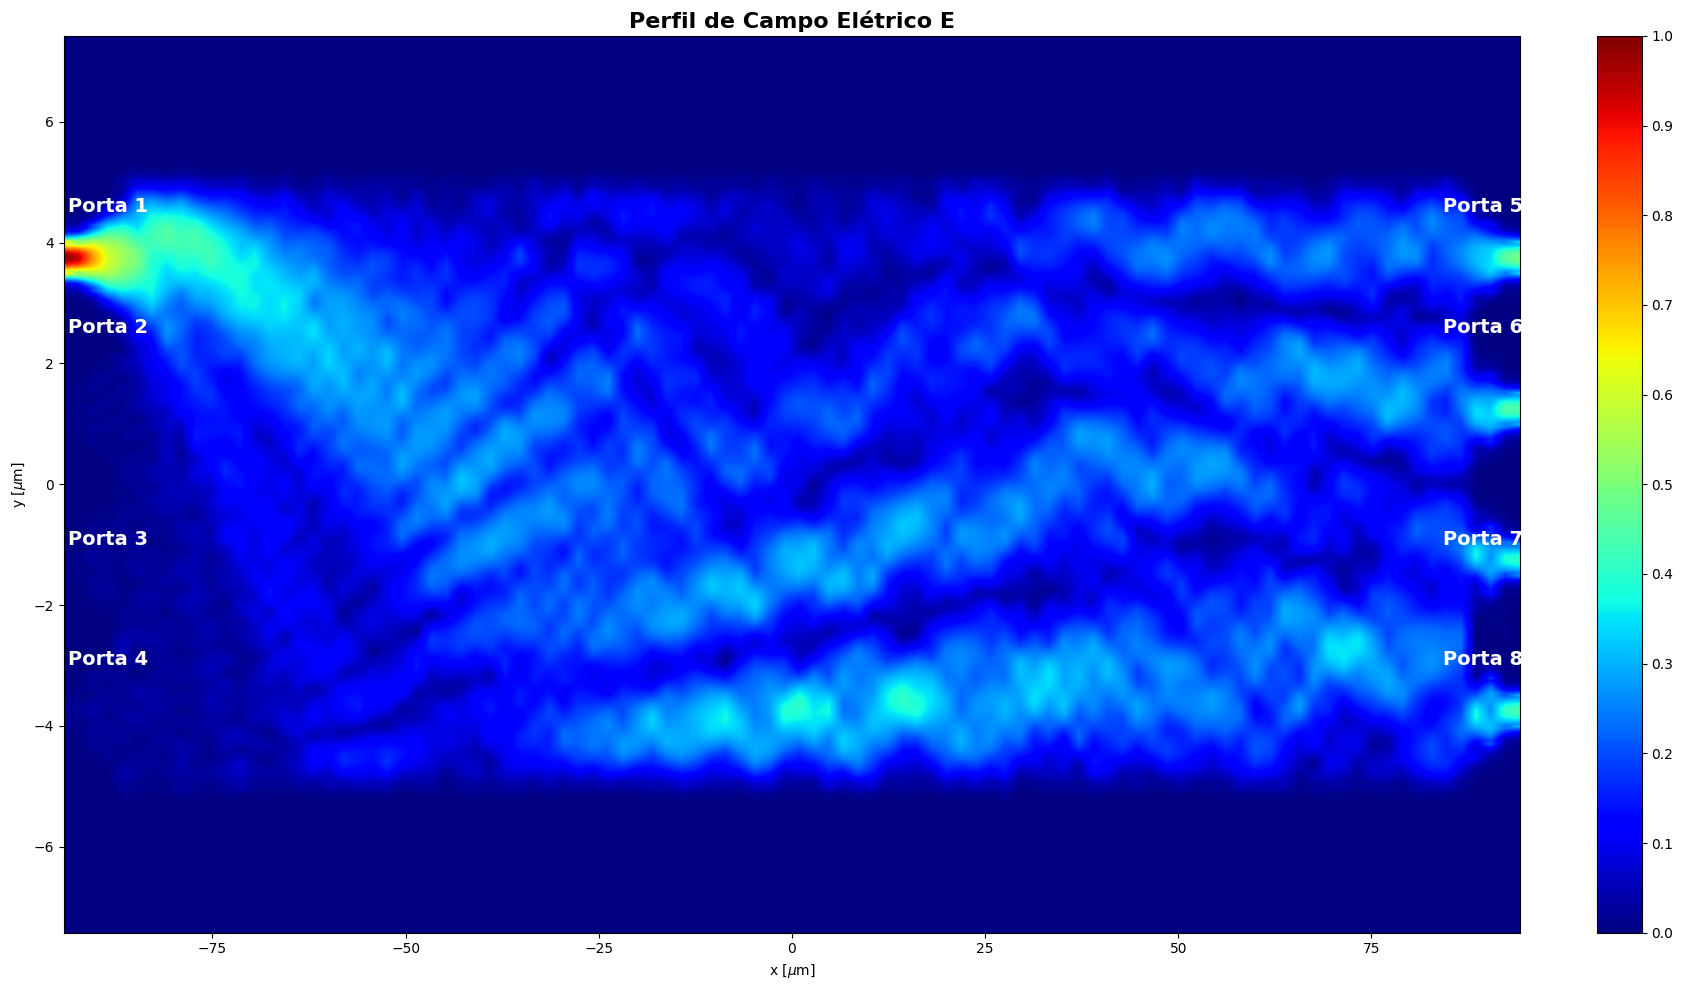

In [30]:
plt.figure(figsize=(20, 10))
mycmap = plt.get_cmap('jet')

v = np.linspace(Emag.min(),1.00001,250,endpoint=True)

plt.contourf(x,y,np.clip(np.transpose(Emag[:,:,0]), v.min(), v.max()),v,cmap = mycmap)
plt.colorbar(ticks=np.linspace(0,1,11, endpoint=True), fraction=0.2, pad=0.04)

plt.title('Perfil de Campo Elétrico E', fontsize = 16, fontweight = 'bold',)
plt.ylabel(r'y [$\mu$m]')
plt.xlabel(r'x [$\mu$m]')

plt.text(-x_waveguide/um, 4.5, 'Porta 1', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, 2.5, 'Porta 2', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -1, 'Porta 3', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -3, 'Porta 4', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 4.5, 'Porta 5', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 2.5, 'Porta 6', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -1, 'Porta 7', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -3, 'Porta 8', fontsize = 14, fontweight = 'bold', color = 'w')

plt.tight_layout()
plt.savefig('Perfil_de_Campo_Eletrico_Linear_EME.png')
plt.show()

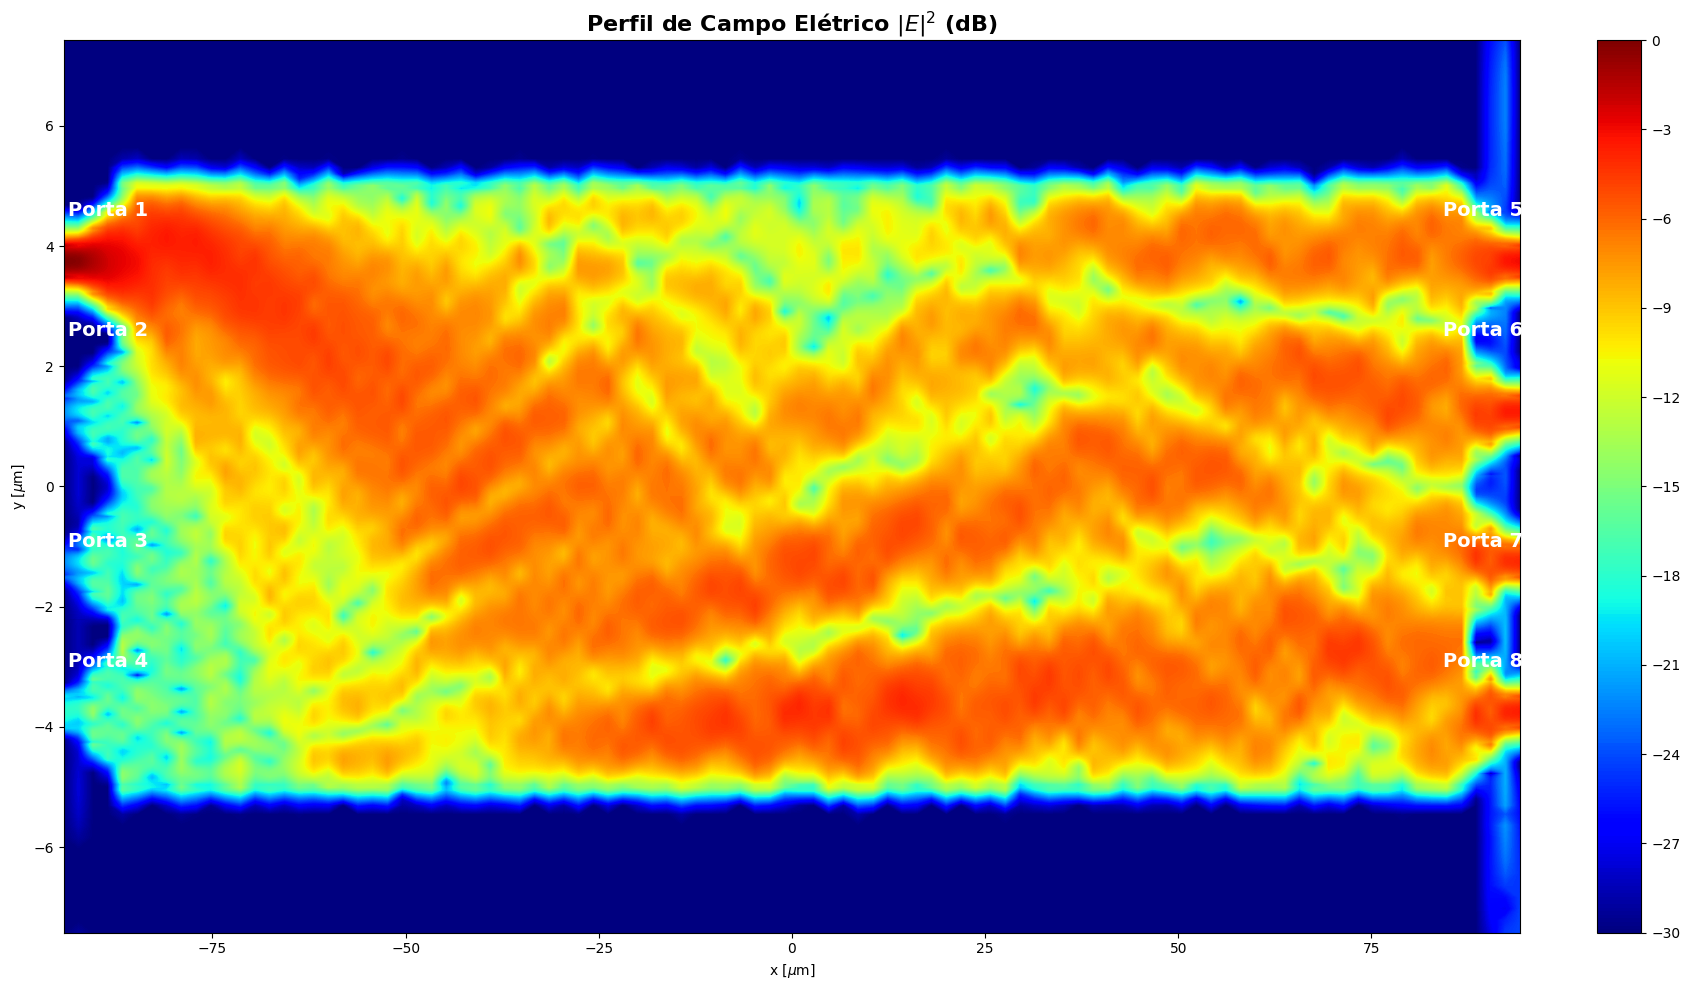

In [31]:
plt.figure(figsize=(20, 10))
mycmap = plt.get_cmap('jet')

v = np.linspace(-30,0.00001,250,endpoint=True)

plt.contourf(x,y,np.clip(np.transpose(Emag_log), v.min(), v.max()),v,cmap = mycmap)
plt.colorbar(ticks=np.linspace(-30,0,11, endpoint=True), fraction=0.2, pad=0.04)

plt.title(r'Perfil de Campo Elétrico $|E|^2$ (dB)', fontsize = 16,  fontweight = 'bold',)
plt.ylabel(r'y [$\mu$m]')
plt.xlabel(r'x [$\mu$m]')

plt.text(-x_waveguide/um, 4.5, 'Porta 1', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, 2.5, 'Porta 2', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -1, 'Porta 3', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -3, 'Porta 4', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 4.5, 'Porta 5', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 2.5, 'Porta 6', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -1, 'Porta 7', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -3, 'Porta 8', fontsize = 14, fontweight = 'bold', color = 'w')

plt.tight_layout()
plt.savefig('Perfil_de_Campo_Eletrico_LOG_EME.png')
plt.show()

In [32]:
modeApi.setemeanalysis('propagation sweep', 1)
modeApi.setemeanalysis('parameter', 'group span 2')
modeApi.setemeanalysis('start', 0.9*comprimento_taper)
modeApi.setemeanalysis('stop', 1.1*comprimento_taper)
modeApi.setemeanalysis('number of points', numberpoint)

In [33]:
modeApi.emesweep('propagation sweep')

In [34]:
S = modeApi.getemesweep('S')
group_span = S['group_span_2']

T1 = np.abs(S['s11'])**2
T5 = np.abs(S['s51'])**2
T6 = np.abs(S['s61'])**2
T7 = np.abs(S['s71'])**2
T8 = np.abs(S['s81'])**2

T1_dB = 10*np.log10(T1)
T5_dB = 10*np.log10(T5)
T6_dB = 10*np.log10(T6)
T7_dB = 10*np.log10(T7)
T8_dB = 10*np.log10(T8)

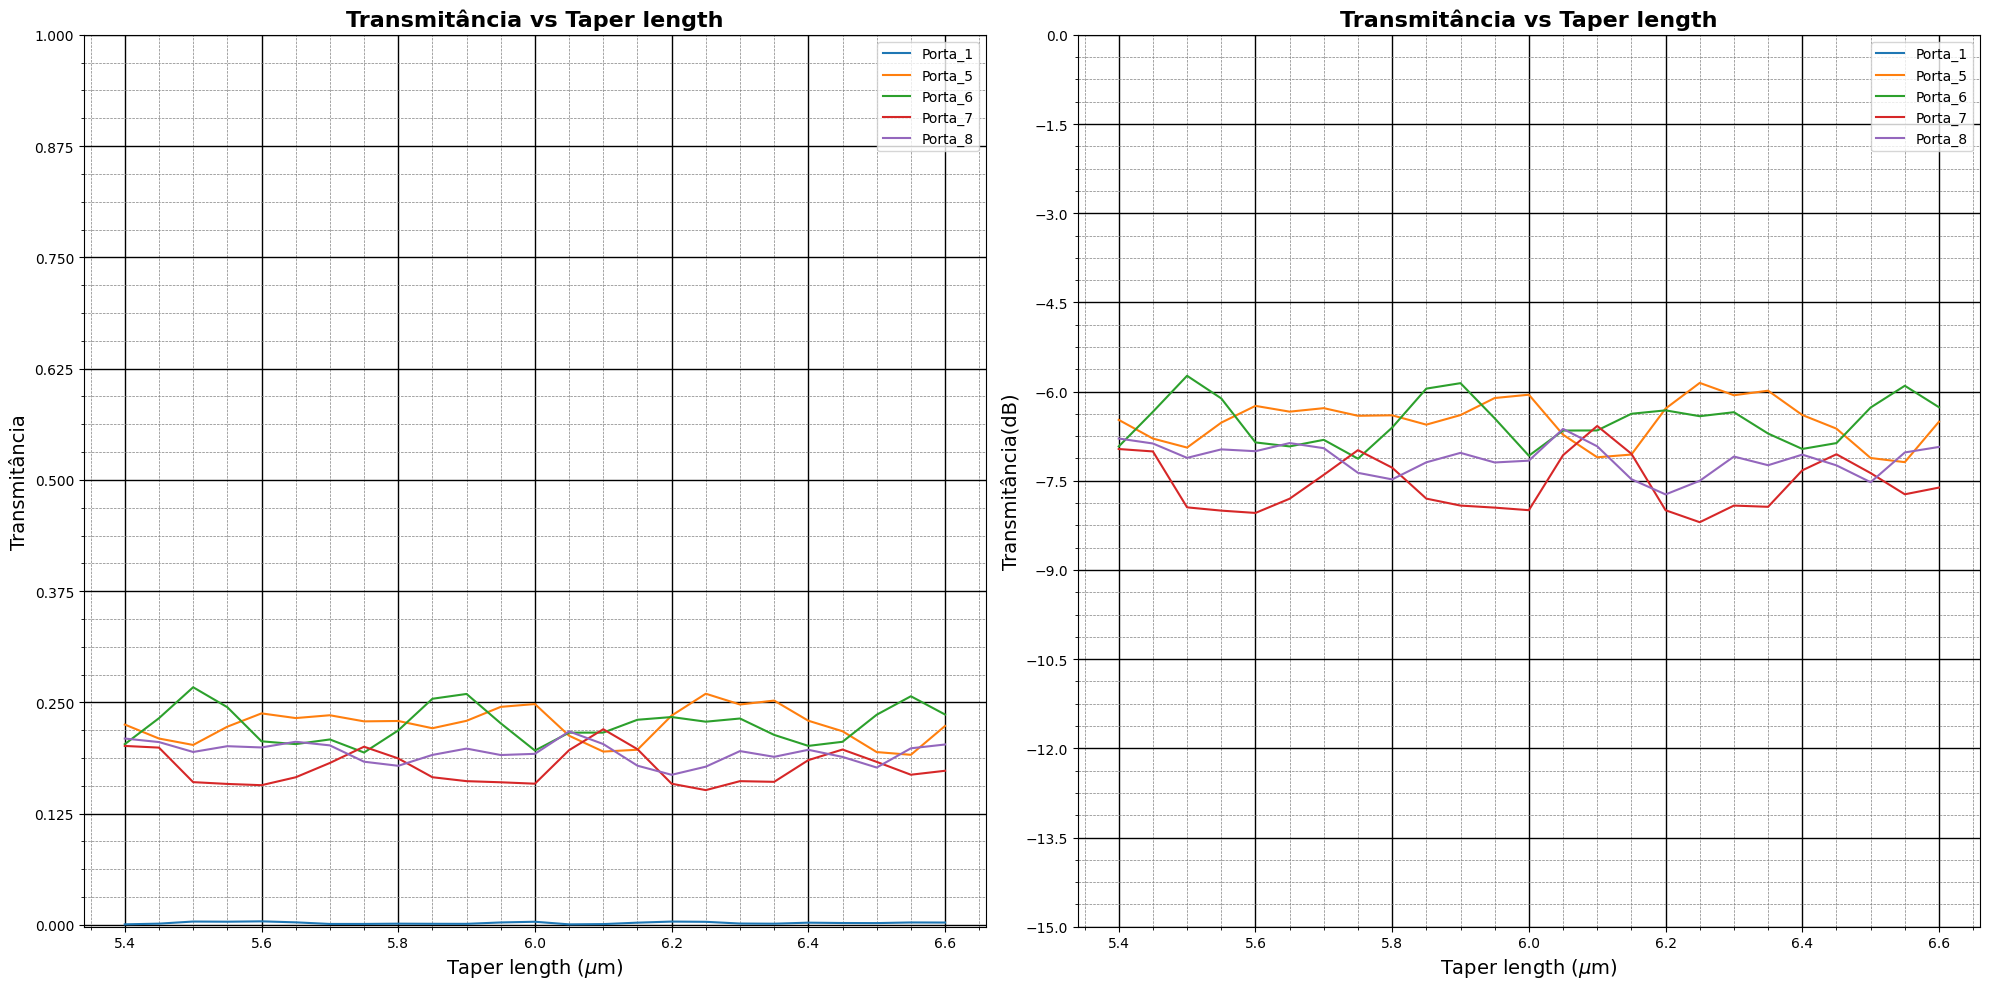

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(group_span/um, T1, lw=1.5, label='Porta_1')
axs[0].plot(group_span/um, T5, lw=1.5, label='Porta_5')
axs[0].plot(group_span/um, T6, lw=1.5, label='Porta_6')
axs[0].plot(group_span/um, T7, lw=1.5, label='Porta_7')
axs[0].plot(group_span/um, T8, lw=1.5, label='Porta_8')
axs[0].set_xlabel(r'Taper length ($\mu$m)', fontsize=14)
axs[0].set_ylabel('Transmitância', fontsize=14)
axs[0].set_title(r'Transmitância vs Taper length', fontsize=16, fontweight = 'bold',)
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].legend()
axs[0].set_ylim([-0.002, 1])
axs[0].set_yticks(np.arange(0, 1.1, 0.125))

axs[1].plot(group_span/um, T1_dB, lw=1.5, label='Porta_1')
axs[1].plot(group_span/um, T5_dB, lw=1.5, label='Porta_5')
axs[1].plot(group_span/um, T6_dB, lw=1.5, label='Porta_6')
axs[1].plot(group_span/um, T7_dB, lw=1.5, label='Porta_7')
axs[1].plot(group_span/um, T8_dB, lw=1.5, label='Porta_8')
axs[1].set_xlabel(r'Taper length ($\mu$m)', fontsize=14)
axs[1].set_ylabel('Transmitância(dB)', fontsize=14)
axs[1].set_title(r'Transmitância vs Taper length', fontsize=16, fontweight = 'bold',)
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].legend()
axs[1].set_ylim([-15, 0])
axs[1].set_yticks(np.arange(-15, 0.1, 1.5))

plt.tight_layout()
plt.savefig('Transmissao_nas_portas_EME_Taper.png')
plt.show()

In [36]:
print(f'Novo comprimento dos Tapers = 6.07\u03BCm')

Novo comprimento dos Tapers = 6.07μm


In [37]:
modeApi.setemeanalysis('propagation sweep', 1)
modeApi.setemeanalysis('parameter', 'group span 3')
modeApi.setemeanalysis('start', 0.9*span_box)
modeApi.setemeanalysis('stop', 1.1*span_box)
modeApi.setemeanalysis('number of points', numberpoint)

In [38]:
modeApi.emesweep('propagation sweep')

In [39]:
S = modeApi.getemesweep('S')
group_span = S['group_span_3']

T1 = np.abs(S['s11'])**2
T5 = np.abs(S['s51'])**2
T6 = np.abs(S['s61'])**2
T7 = np.abs(S['s71'])**2
T8 = np.abs(S['s81'])**2

T1_dB = 10*np.log10(T1)
T5_dB = 10*np.log10(T5)
T6_dB = 10*np.log10(T6)
T7_dB = 10*np.log10(T7)
T8_dB = 10*np.log10(T8)


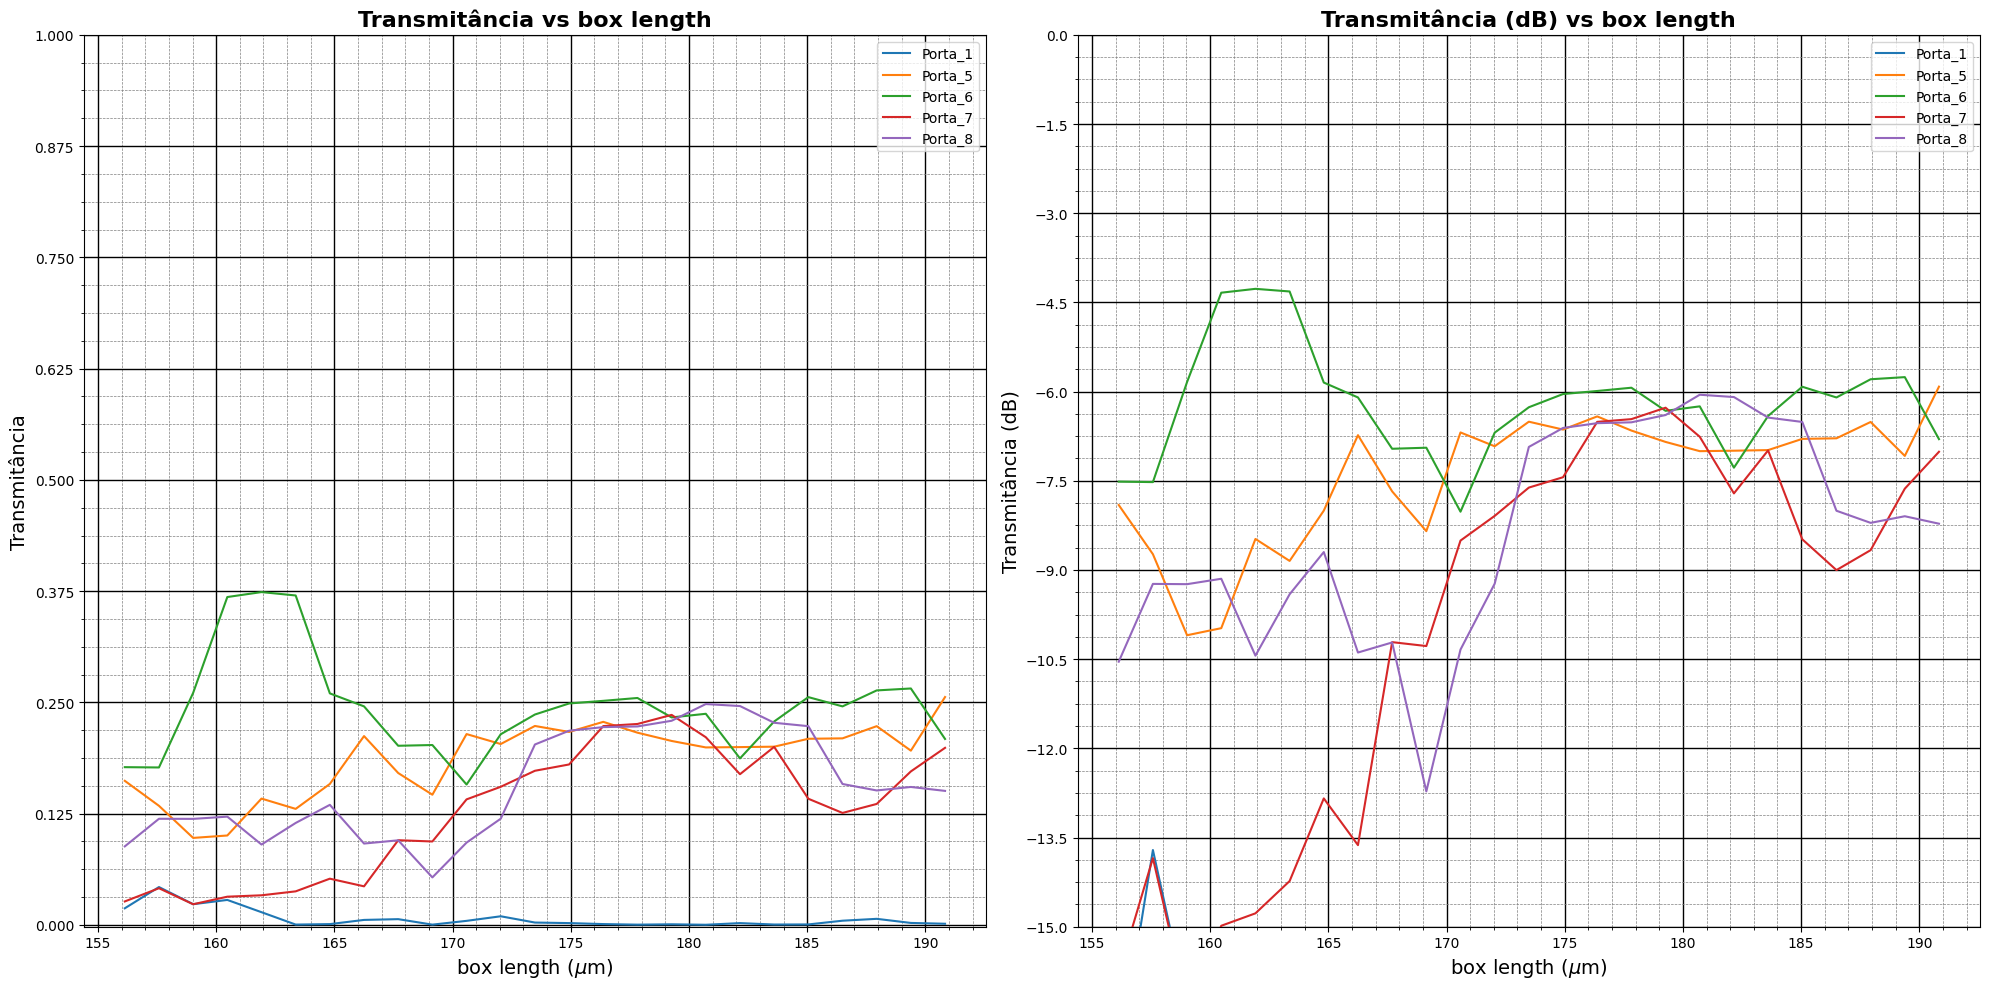

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(group_span/um, T1, lw=1.5, label='Porta_1')
axs[0].plot(group_span/um, T5, lw=1.5, label='Porta_5')
axs[0].plot(group_span/um, T6, lw=1.5, label='Porta_6')
axs[0].plot(group_span/um, T7, lw=1.5, label='Porta_7')
axs[0].plot(group_span/um, T8, lw=1.5, label='Porta_8')
axs[0].set_xlabel(r'box length ($\mu$m)', fontsize=14)
axs[0].set_ylabel('Transmitância', fontsize=14)
axs[0].set_title(r'Transmitância vs box length', fontsize=16, fontweight = 'bold',)
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].legend()
axs[0].set_ylim([-0.002, 1])
axs[0].set_yticks(np.arange(0, 1.1, 0.125))

axs[1].plot(group_span/um, T1_dB, lw=1.5, label='Porta_1')
axs[1].plot(group_span/um, T5_dB, lw=1.5, label='Porta_5')
axs[1].plot(group_span/um, T6_dB, lw=1.5, label='Porta_6')
axs[1].plot(group_span/um, T7_dB, lw=1.5, label='Porta_7')
axs[1].plot(group_span/um, T8_dB, lw=1.5, label='Porta_8')
axs[1].set_xlabel(r'box length ($\mu$m)', fontsize=14)
axs[1].set_ylabel('Transmitância (dB)', fontsize=14)
axs[1].set_title(r'Transmitância (dB) vs box length', fontsize=16, fontweight = 'bold',)
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].legend()
axs[1].set_ylim([-15, 0])
axs[1].set_yticks(np.arange(-15, 0.1, 1.5))

plt.tight_layout()
plt.savefig('Transmissao_nas_portas_EME_BOX.png')
plt.show()

In [41]:
print(f'Novo comprimento da caixa central = 176.5\u03BCm')

Novo comprimento da caixa central = 176.5μm


In [42]:
modeApi.setemeanalysis('wavelength sweep', 1)
modeApi.setemeanalysis('start wavelength', lmbd_start)
modeApi.setemeanalysis('stop wavelength', lmbd_stop)
modeApi.setemeanalysis('number of wavelength points', numberpoint)
modeApi.setemeanalysis('calculate group delays', 1)

In [43]:
modeApi.emesweep('wavelength sweep')
S = modeApi.getemesweep('S_wavelength_sweep')
Lambda = S['wavelength']/nm

T1 = np.abs(S['s11'])**2
T5 = np.abs(S['s51'])**2
T6 = np.abs(S['s61'])**2
T7 = np.abs(S['s71'])**2
T8 = np.abs(S['s81'])**2

T1_dB = 10*np.log10(T1)
T5_dB = 10*np.log10(T5)
T6_dB = 10*np.log10(T6)
T7_dB = 10*np.log10(T7)
T8_dB = 10*np.log10(T8)

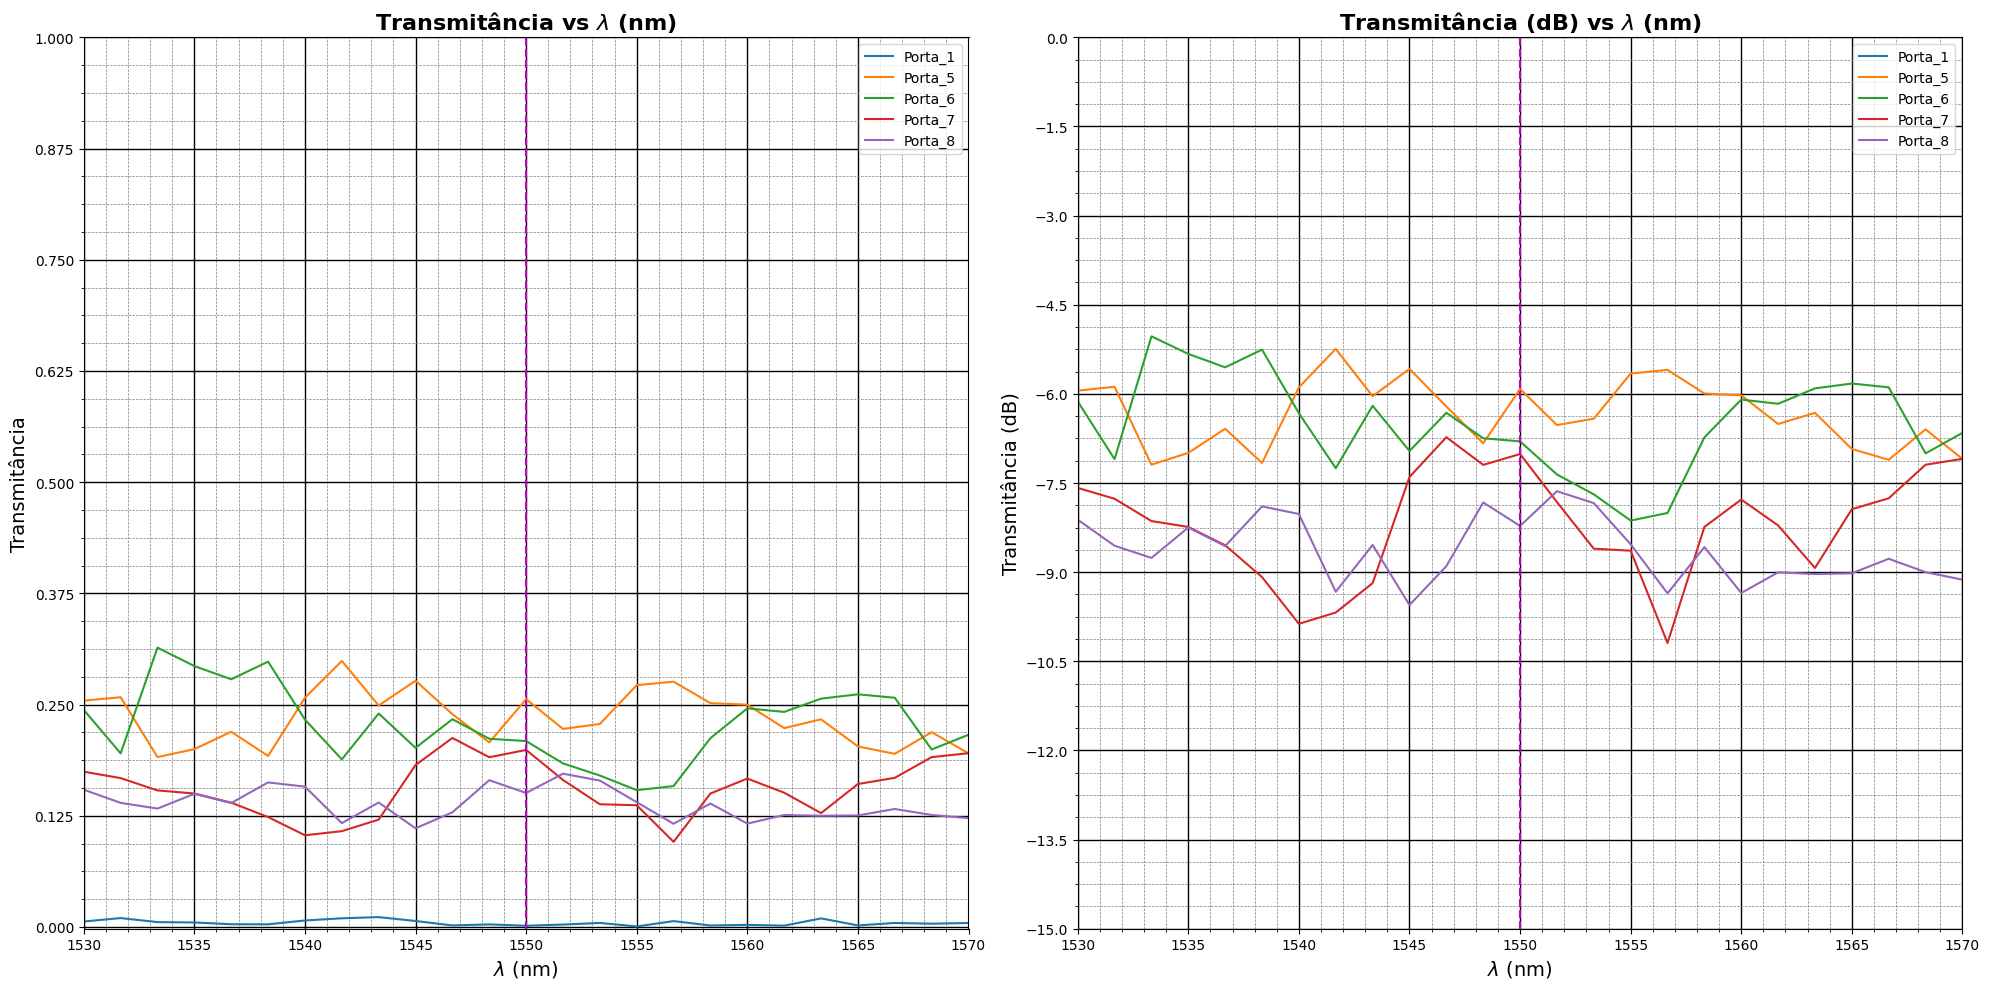

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(Lambda, T1, lw=1.5, label='Porta_1')
axs[0].plot(Lambda, T5, lw=1.5, label='Porta_5')
axs[0].plot(Lambda, T6, lw=1.5, label='Porta_6')
axs[0].plot(Lambda, T7, lw=1.5, label='Porta_7')
axs[0].plot(Lambda, T8, lw=1.5, label='Porta_8')
axs[0].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[0].set_ylabel('Transmitância', fontsize=14)
axs[0].set_title(r'Transmitância vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold',)
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].legend()
axs[0].set_xlim([1530, 1570])
axs[0].set_ylim([-0.002, 1])
axs[0].set_yticks(np.arange(0, 1.1, 0.125))
axs[0].axvline(x=lmbd/nm, color='m', linestyle='--')


axs[1].plot(Lambda, T1_dB, lw=1.5, label='Porta_1')
axs[1].plot(Lambda, T5_dB, lw=1.5, label='Porta_5')
axs[1].plot(Lambda, T6_dB, lw=1.5, label='Porta_6')
axs[1].plot(Lambda, T7_dB, lw=1.5, label='Porta_7')
axs[1].plot(Lambda, T8_dB, lw=1.5, label='Porta_8')
axs[1].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[1].set_ylabel('Transmitância (dB)', fontsize=14)
axs[1].set_title(r'Transmitância (dB) vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold',)
axs[1].set_ylim([-15, 0])
axs[1].set_xlim([1530, 1570])
axs[1].set_yticks(np.arange(-15, 0.1, 1.5))
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].legend()
axs[1].axvline(x=lmbd/nm, color='m', linestyle='--')

plt.tight_layout()
plt.savefig('Transmissao_nas_portas_EME.png')
plt.show()

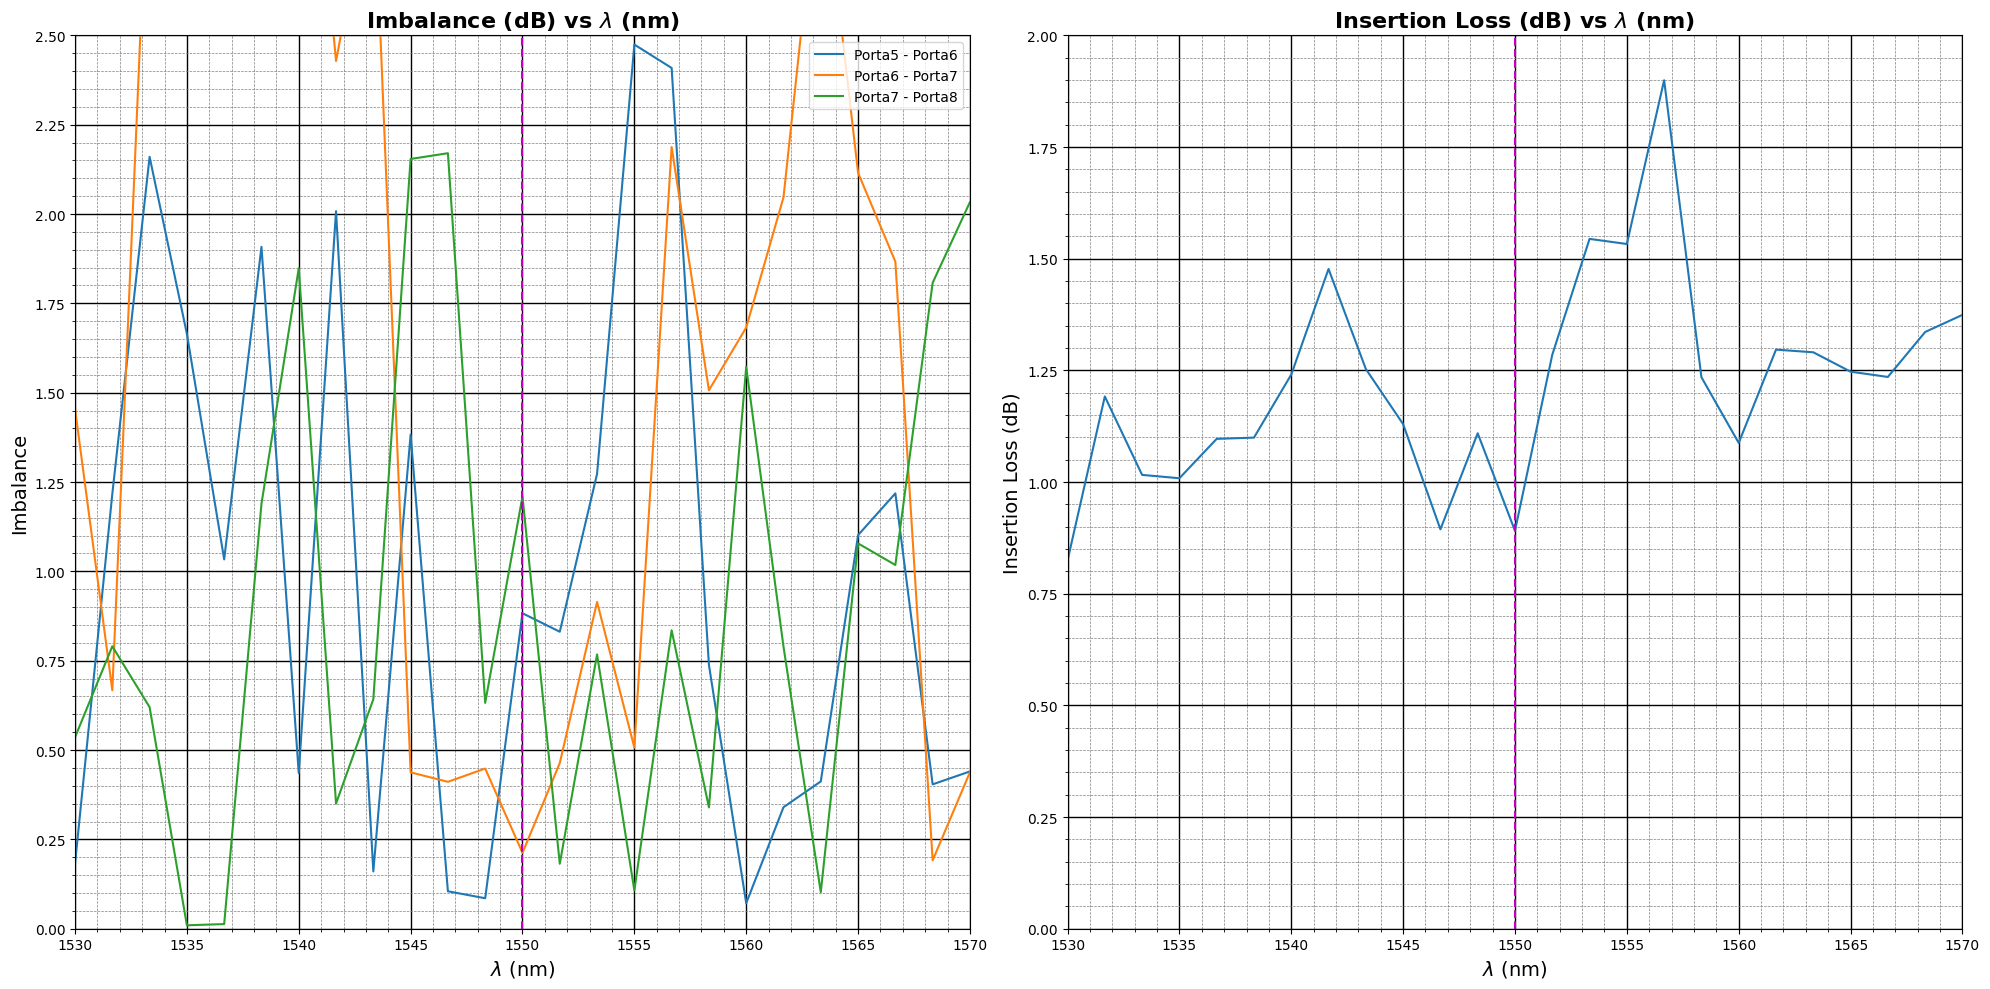

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

Ib1 = np.abs(T5_dB - T6_dB)
Ib2 = np.abs(T6_dB - T7_dB)
Ib3 = np.abs(T7_dB - T8_dB)
axs[0].plot(Lambda, Ib1, lw=1.5, label='Porta5 - Porta6')
axs[0].plot(Lambda, Ib2, lw=1.5, label='Porta6 - Porta7')
axs[0].plot(Lambda, Ib3, lw=1.5, label='Porta7 - Porta8')
axs[0].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[0].set_ylabel('Imbalance', fontsize=14)
axs[0].set_title(r'Imbalance (dB) vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold')
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[0].legend()
axs[0].set_xlim([1530,1570])
axs[0].set_ylim([0,2.5])
axs[0].set_yticks(np.arange(0, 2.6, 0.25))

Il = -10*np.log10(T5 + T6 + T7 + T8)
axs[1].plot(Lambda, Il, lw=1.5)
axs[1].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[1].set_ylabel('Insertion Loss (dB)', fontsize=14)
axs[1].set_title(r'Insertion Loss (dB) vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold')
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[1].set_xlim([1530,1570])
axs[1].set_ylim([0,2])
axs[1].set_yticks(np.arange(0, 2.1, 0.25))


plt.tight_layout()
plt.savefig('Imbalance_e_Perda_de_Insercao_nas_portas_EME.png')
plt.show()

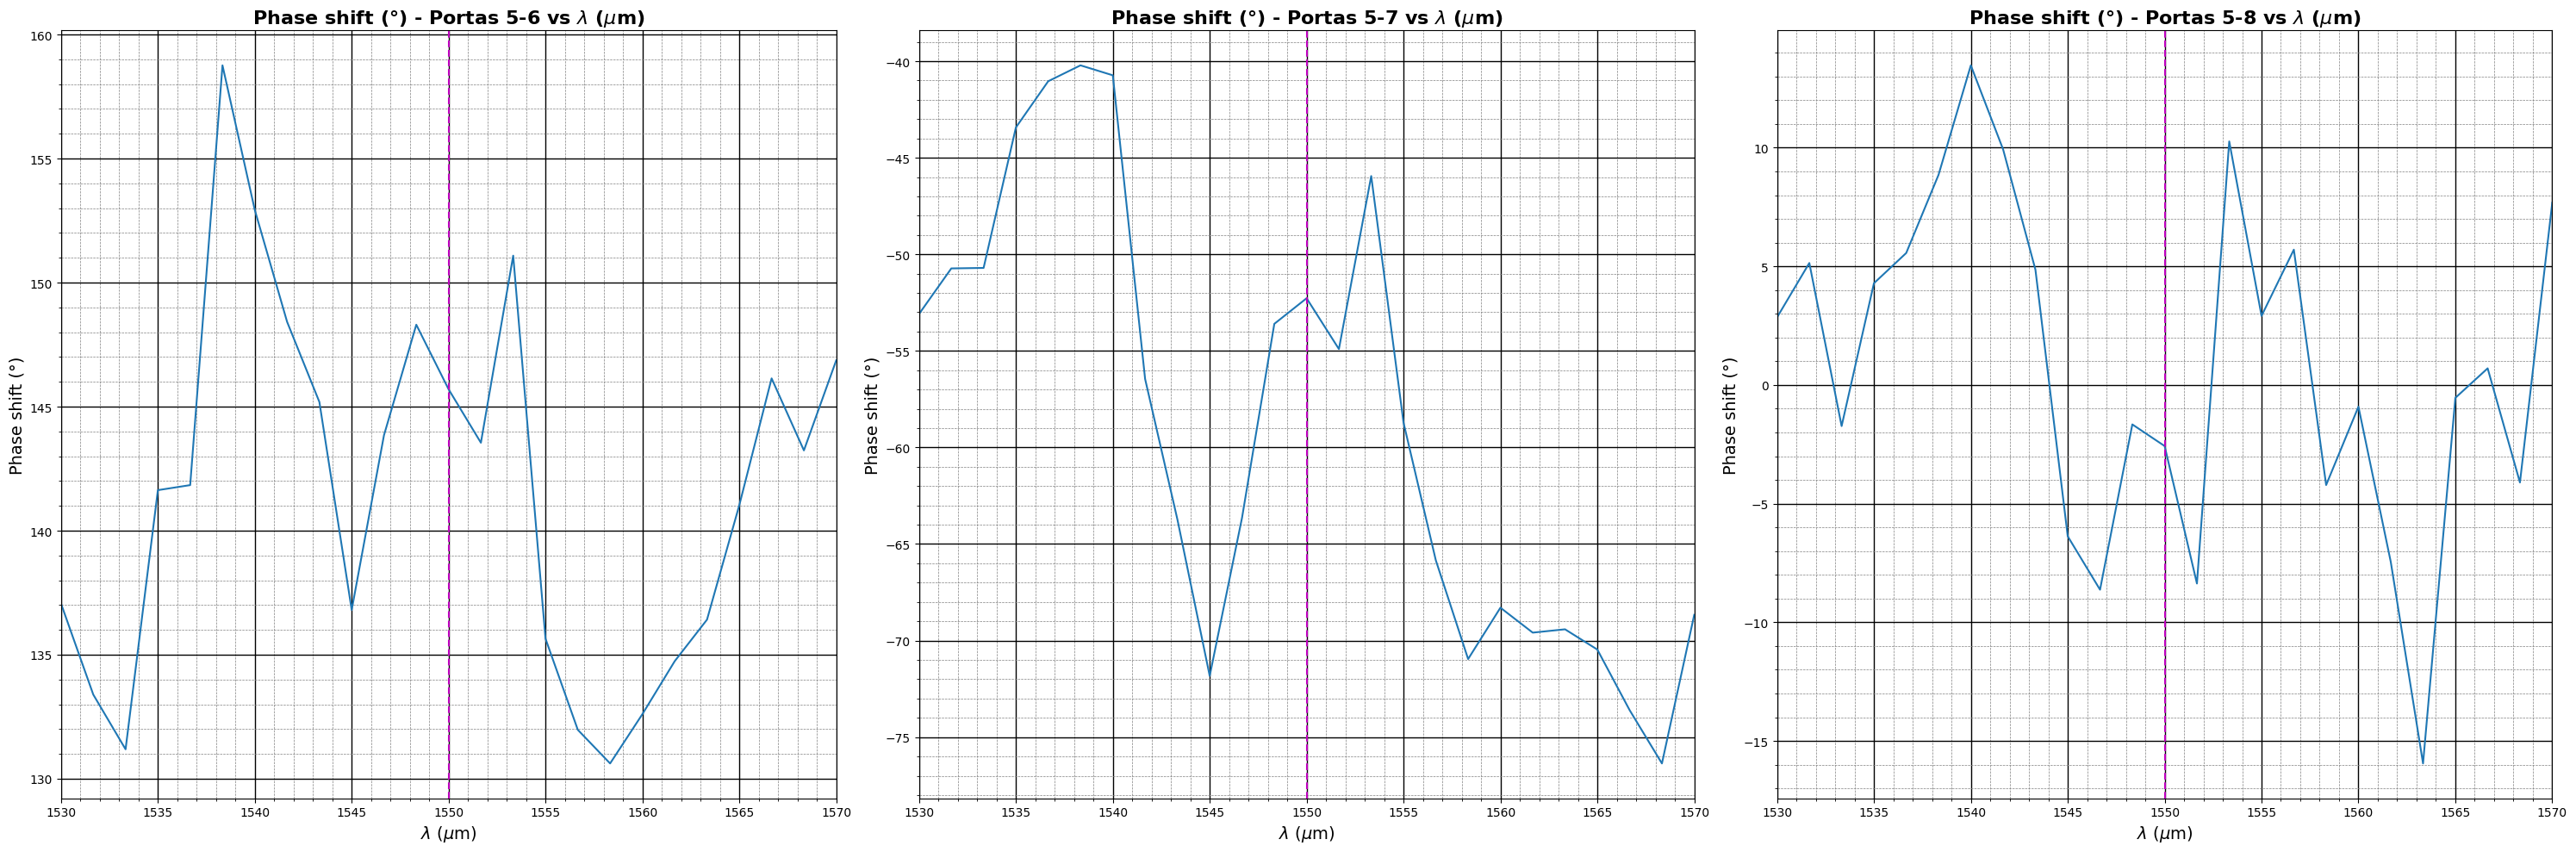

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

phi1 = np.angle(S['s51'])
phi2 = np.angle(S['s61'])
phi3 = np.angle(S['s71'])
phi4 = np.angle(S['s81'])

phase = (phi1 - phi2) * (180 / np.pi)

len_phase = len(phase)

for p in range(len_phase):
    if phase[p] > 180:
        phase[p] = phase[p] - 360
    if phase[p] < -180:
        phase[p] = phase[p] + 360

axs[0].plot(Lambda, phase, lw=1.5)
axs[0].set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=14)
axs[0].set_ylabel("Phase shift (°)", fontsize=14)
axs[0].set_title(r"Phase shift (°) - Portas 5-6 vs $\lambda$ ($\mu$m)", fontsize=16, fontweight = 'bold')
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[0].set_xlim([1530,1570])

phase = (phi1 - phi3) * (180 / np.pi)

for p in range(len_phase):
    if phase[p] > 180:
        phase[p] = phase[p] - 360
    if phase[p] < -180:
        phase[p] = phase[p] + 360

axs[1].plot(Lambda, phase, lw=1.5)
axs[1].set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=14)
axs[1].set_ylabel("Phase shift (°)", fontsize=14)
axs[1].set_title(r"Phase shift (°) - Portas 5-7 vs $\lambda$ ($\mu$m)", fontsize=16, fontweight = 'bold')
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[1].set_xlim([1530,1570])

phase = (phi1 - phi4) * (180 / np.pi)

for p in range(len_phase):
    if phase[p] > 180:
        phase[p] = phase[p] - 360
    if phase[p] < -180:
        phase[p] = phase[p] + 360

axs[2].plot(Lambda, phase, lw=1.5)
axs[2].set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=14)
axs[2].set_ylabel("Phase shift (°)", fontsize=14)
axs[2].set_title(r"Phase shift (°) - Portas 5-8 vs $\lambda$ ($\mu$m)", fontsize=16, fontweight = 'bold')
axs[2].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[2].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[2].minorticks_on()
axs[2].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[2].set_xlim([1530,1570])

plt.tight_layout()
plt.savefig('Fase_nas_portas_EME.png')
plt.show()

In [47]:
L = 176.5*um
comprimento_taper = 6*um

x_taper = L/2 + comprimento_taper/2
y_taper = (espassamento + espessura_taper)/2
z_taper = z_MMI

x_waveguide =  L/2 + comprimento_taper + comprimento/2
y_waveguide = y_taper
z_waveguide = z_taper

x_EME_span = L + comprimento_taper*2 + comprimento*2
x_EME = x_EME_span/2 - 0.5*um

In [48]:
modeApi.switchtolayout()

modeApi.select(f'{dev_layer}::Box')
modeApi.set('x span', L)

for i in range(1,9):
    taper_name = f'{dev_layer}::Taper_{i}'
    modeApi.select(taper_name)
    modeApi.set("len", comprimento_taper)
    modeApi.set("z", z_taper)
    if i<=4:
        modeApi.set('x', -x_taper)
        if i==1 or i==4:
            modeApi.set('y', -(-1)**i*y_taper*3)
        else:
            modeApi.set('y', (-1)**i*y_taper)
    else:
        modeApi.set('x', x_taper)
        if i==5 or i==8:
            modeApi.set('y', -(-1)**i*y_taper*3)
        else:
            modeApi.set('y', (-1)**i*y_taper)

for i in range(1,9):
    waveguide_name = f'{dev_layer}::Waveguide_{i}'
    modeApi.select(waveguide_name)
    modeApi.set('z', z_waveguide)
    if i<=4:
        modeApi.set('x', -x_waveguide)
        if i==1 or i==4:
            modeApi.set('y', -(-1)**i*y_waveguide*3)
        else:
            modeApi.set('y', (-1)**i*y_waveguide)
    else:
        modeApi.set('x', x_waveguide)
        if i==5 or i==8:
            modeApi.set('y', -(-1)**i*y_waveguide*3)
        else:
            modeApi.set('y', (-1)**i*y_waveguide)


In [49]:
modeApi.switchtolayout()

modeApi.select('EME')
modeApi.set("x min", -x_EME)

span_box = L
span_taper = comprimento_taper

modeApi.set("number of cell groups", 5)
modeApi.set("group spans", np.block([[span_waveguide], [span_taper], [span_box], [span_taper], [span_waveguide]]))
modeApi.set("cells", np.block([[cell_waveguide], [cell_taper], [cell_box], [cell_taper], [cell_waveguide]]))
modeApi.set("subcell method", np.block([[method_waveguide], [method_taper], [method_box], [method_taper], [method_waveguide]]))
modeApi.set("allow custom eigensolver settings", True)
modeApi.set("modes", np.block([[modes_waveguide], [modes_taper], [modes_box], [modes_taper], [modes_waveguide]]))
modeApi.set("display cells", 1)

modeApi.select("Monitor")
modeApi.set("x span", x_EME_span)

modeApi.save('MMI_SIMULACAO - EME')

In [50]:
modeApi.run()

In [51]:
modeApi.emepropagate()

In [52]:
E = modeApi.getresult('Monitor', 'field profile')

x = E['x']
x = x[:,0]/um

y = E['y']
y = y[:,0]/um

z = E['z']
E = E['E']

Ex = E[:,:,0,:,0]
Ey = E[:,:,0,:,1]
Ez = E[:,:,0,:,2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + Ez**2)
Emag_log = 10*np.log10((Emag[:,:,0]))

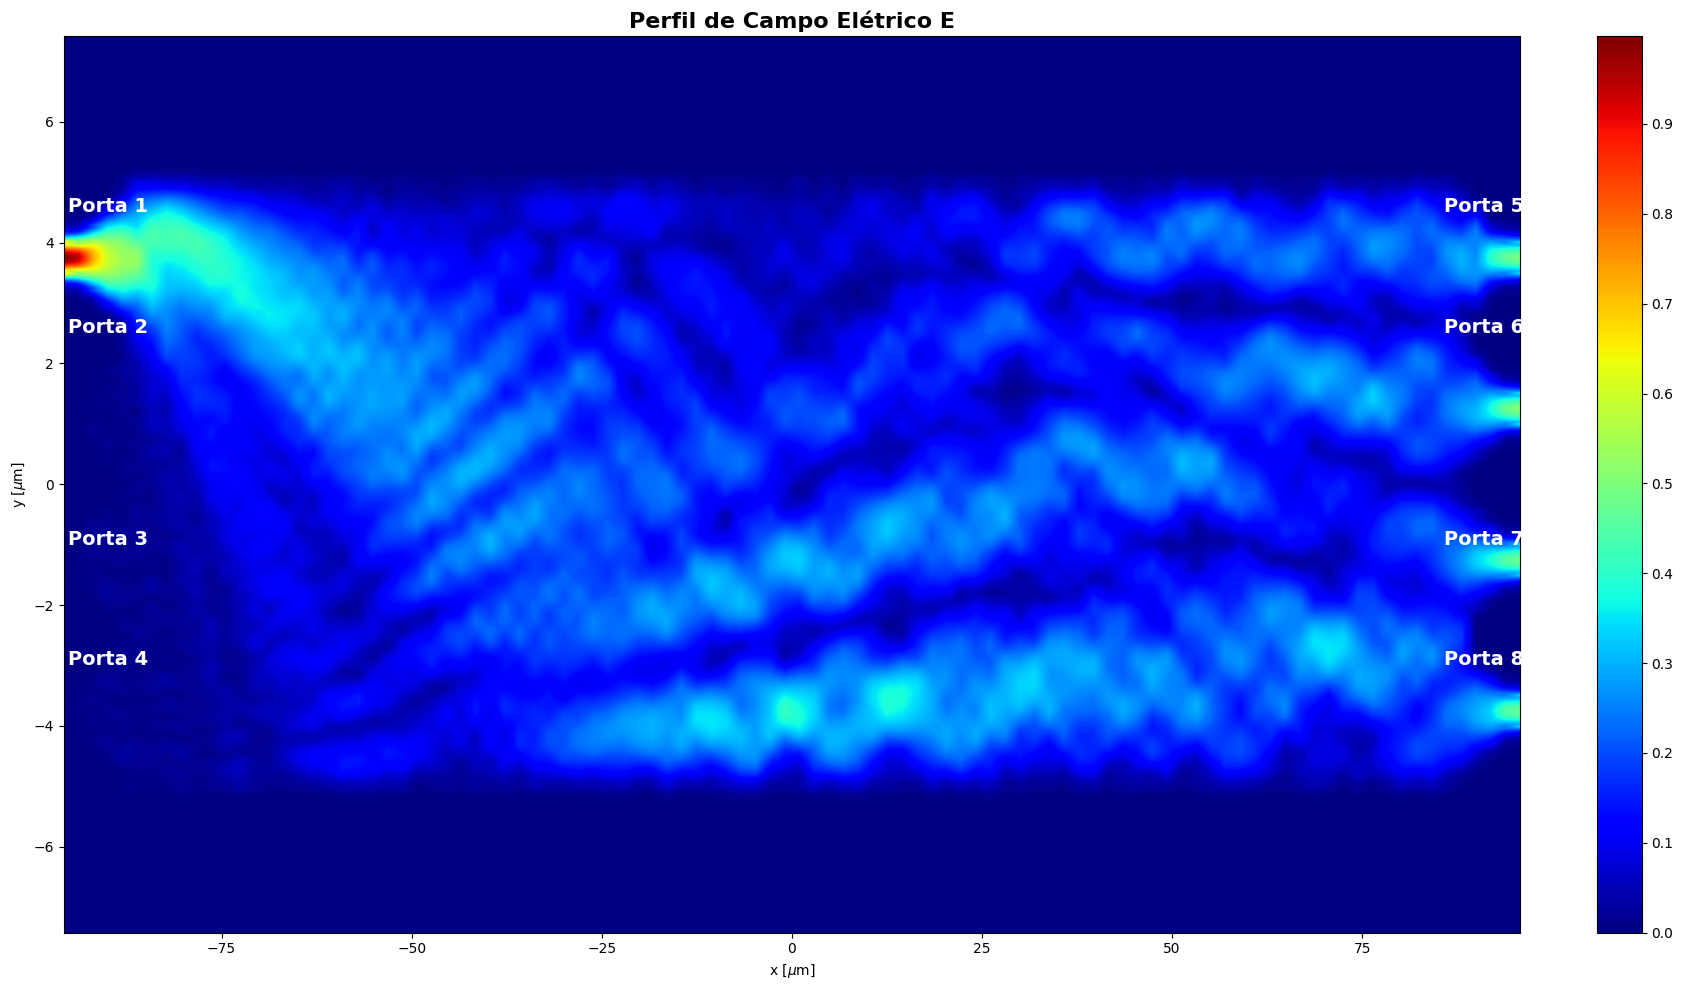

In [53]:
plt.figure(figsize=(20, 10))
mycmap = plt.get_cmap('jet')

v = np.linspace(Emag.min(),1.00001,250,endpoint=True)

plt.contourf(x,y,np.clip(np.transpose(Emag[:,:,0]), v.min(), v.max()),v,cmap = mycmap)
plt.colorbar(ticks=np.linspace(0,1,11, endpoint=True), fraction=0.2, pad=0.04)

plt.title('Perfil de Campo Elétrico E', fontsize = 16, fontweight = 'bold',)
plt.ylabel(r'y [$\mu$m]')
plt.xlabel(r'x [$\mu$m]')

plt.text(-x_waveguide/um, 4.5, 'Porta 1', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, 2.5, 'Porta 2', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -1, 'Porta 3', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -3, 'Porta 4', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 4.5, 'Porta 5', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 2.5, 'Porta 6', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -1, 'Porta 7', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -3, 'Porta 8', fontsize = 14, fontweight = 'bold', color = 'w')

plt.tight_layout()
plt.savefig('Perfil_de_Campo_Elétrico_Linear_EME_NEW.png')
plt.show()

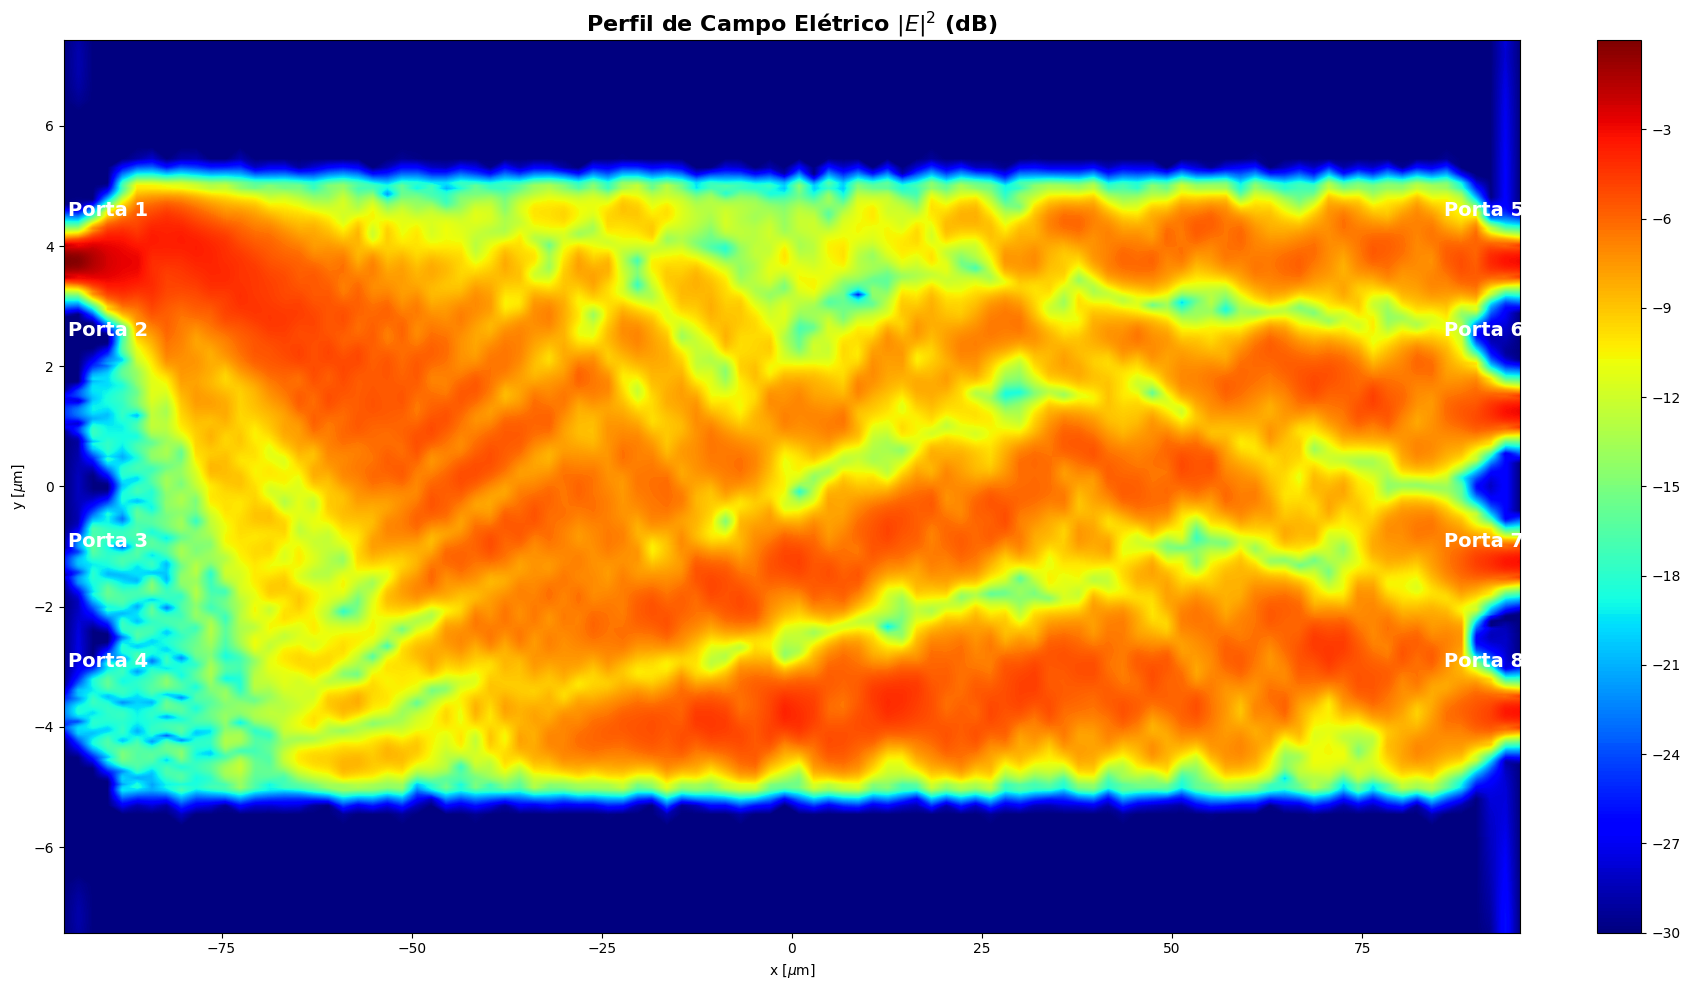

In [54]:
plt.figure(figsize=(20, 10))
mycmap = plt.get_cmap('jet')

v = np.linspace(-30,0.00001,250,endpoint=True)

plt.contourf(x,y,np.clip(np.transpose(Emag_log), v.min(), v.max()),v,cmap = mycmap)
plt.colorbar(ticks=np.linspace(-30,0,11, endpoint=True), fraction=0.2, pad=0.04)

plt.title(r'Perfil de Campo Elétrico $|E|^2$ (dB)', fontsize = 16,  fontweight = 'bold',)
plt.ylabel(r'y [$\mu$m]')
plt.xlabel(r'x [$\mu$m]')

plt.text(-x_waveguide/um, 4.5, 'Porta 1', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, 2.5, 'Porta 2', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -1, 'Porta 3', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -3, 'Porta 4', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 4.5, 'Porta 5', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 2.5, 'Porta 6', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -1, 'Porta 7', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -3, 'Porta 8', fontsize = 14, fontweight = 'bold', color = 'w')

plt.tight_layout()
plt.savefig('Perfil_de_Campo_Eletrico_LOG_EME_NEW.png')
plt.show()

In [55]:
modeApi.setemeanalysis('wavelength sweep', 1)
modeApi.setemeanalysis('start wavelength', lmbd_start)
modeApi.setemeanalysis('stop wavelength', lmbd_stop)
modeApi.setemeanalysis('number of wavelength points', numberpoint)
modeApi.setemeanalysis('calculate group delays', 1)

In [56]:
modeApi.emesweep('wavelength sweep')
S = modeApi.getemesweep('S_wavelength_sweep')
Lambda = S['wavelength']/nm

T1 = np.abs(S['s11'])**2
T5 = np.abs(S['s51'])**2
T6 = np.abs(S['s61'])**2
T7 = np.abs(S['s71'])**2
T8 = np.abs(S['s81'])**2

T1_dB = 10*np.log10(T1)
T5_dB = 10*np.log10(T5)
T6_dB = 10*np.log10(T6)
T7_dB = 10*np.log10(T7)
T8_dB = 10*np.log10(T8)

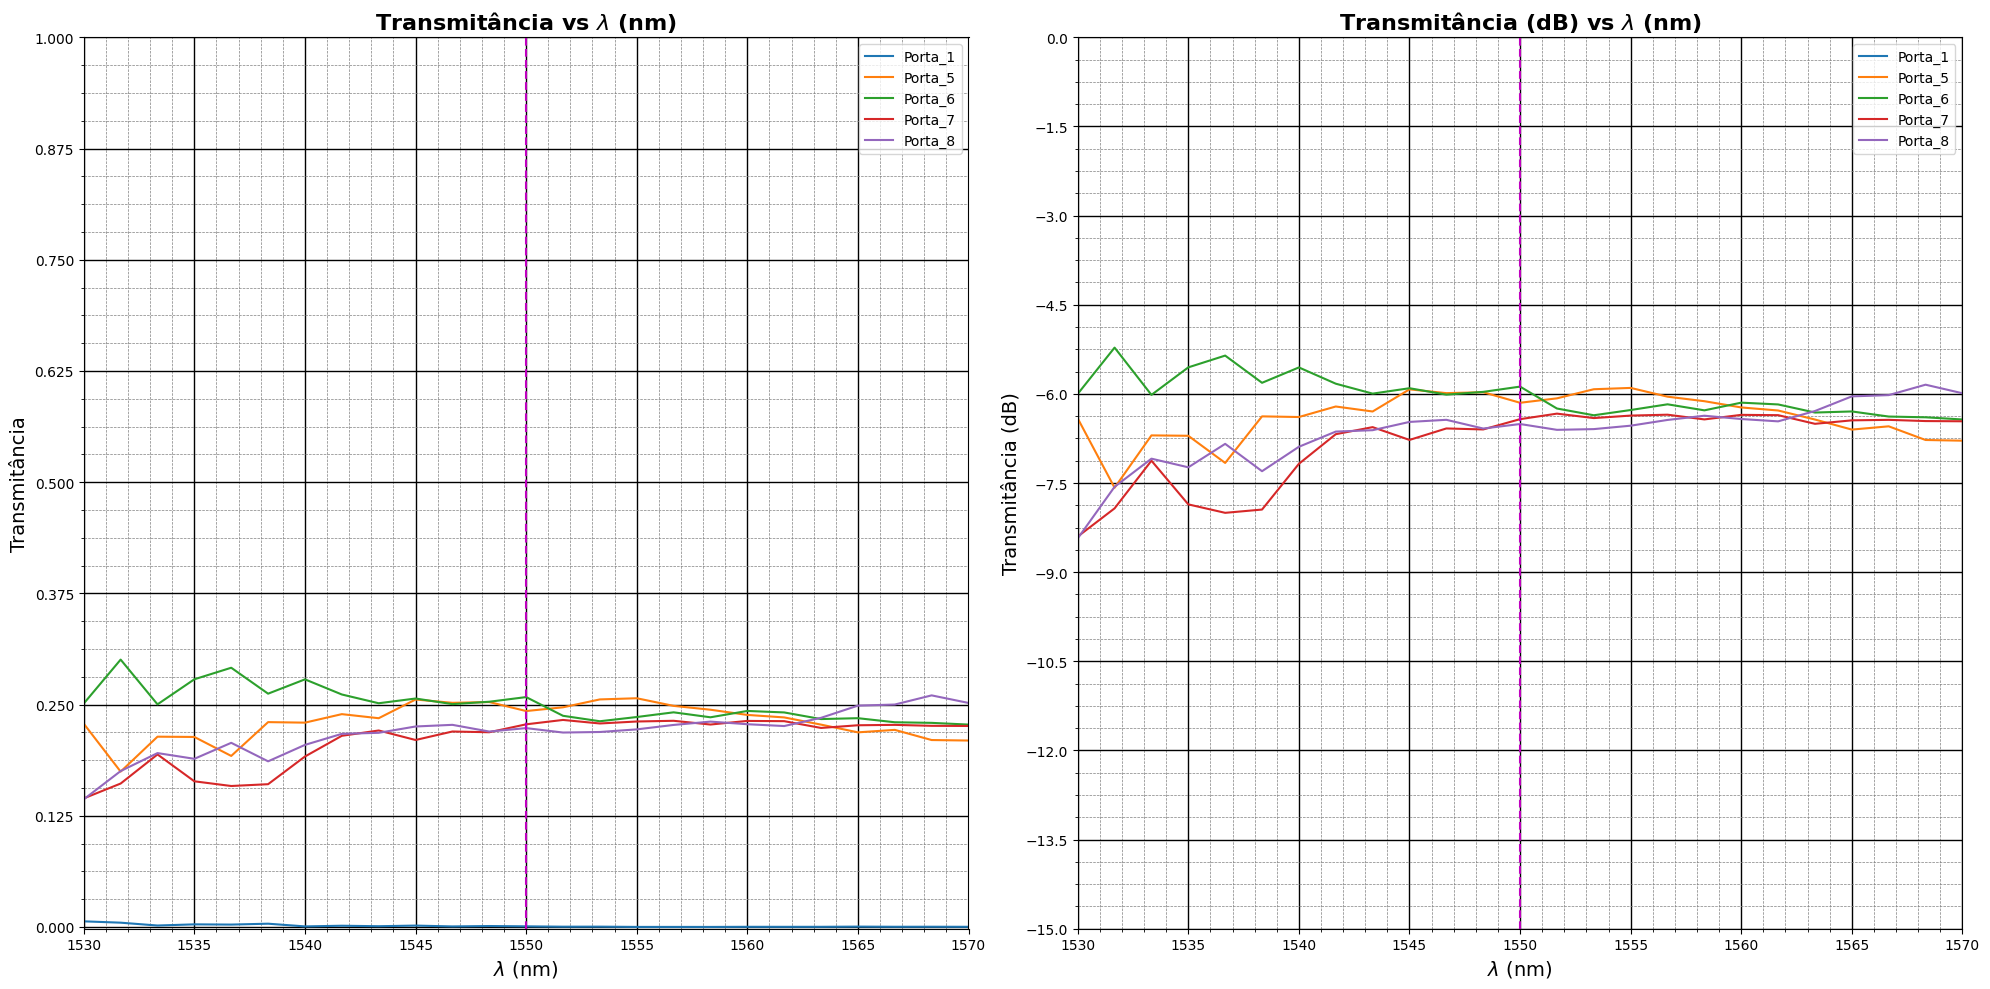

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(Lambda, T1, lw=1.5, label='Porta_1')
axs[0].plot(Lambda, T5, lw=1.5, label='Porta_5')
axs[0].plot(Lambda, T6, lw=1.5, label='Porta_6')
axs[0].plot(Lambda, T7, lw=1.5, label='Porta_7')
axs[0].plot(Lambda, T8, lw=1.5, label='Porta_8')
axs[0].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[0].set_ylabel('Transmitância', fontsize=14)
axs[0].set_title(r'Transmitância vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold',)
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].legend()
axs[0].set_xlim([1530, 1570])
axs[0].set_ylim([-0.002, 1])
axs[0].set_yticks(np.arange(0, 1.1, 0.125))
axs[0].axvline(x=lmbd/nm, color='m', linestyle='--')

axs[1].plot(Lambda, T1_dB, lw=1.5, label='Porta_1')
axs[1].plot(Lambda, T5_dB, lw=1.5, label='Porta_5')
axs[1].plot(Lambda, T6_dB, lw=1.5, label='Porta_6')
axs[1].plot(Lambda, T7_dB, lw=1.5, label='Porta_7')
axs[1].plot(Lambda, T8_dB, lw=1.5, label='Porta_8')
axs[1].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[1].set_ylabel('Transmitância (dB)', fontsize=14)
axs[1].set_title(r'Transmitância (dB) vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold',)
axs[1].set_ylim([-15, 0])
axs[1].set_xlim([1530, 1570])
axs[1].set_yticks(np.arange(-15, 0.1, 1.5))
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].legend()
axs[1].axvline(x=lmbd/nm, color='m', linestyle='--')

plt.tight_layout()
plt.savefig('Transmissao_nas_portas_EME_NEW.png')
plt.show()

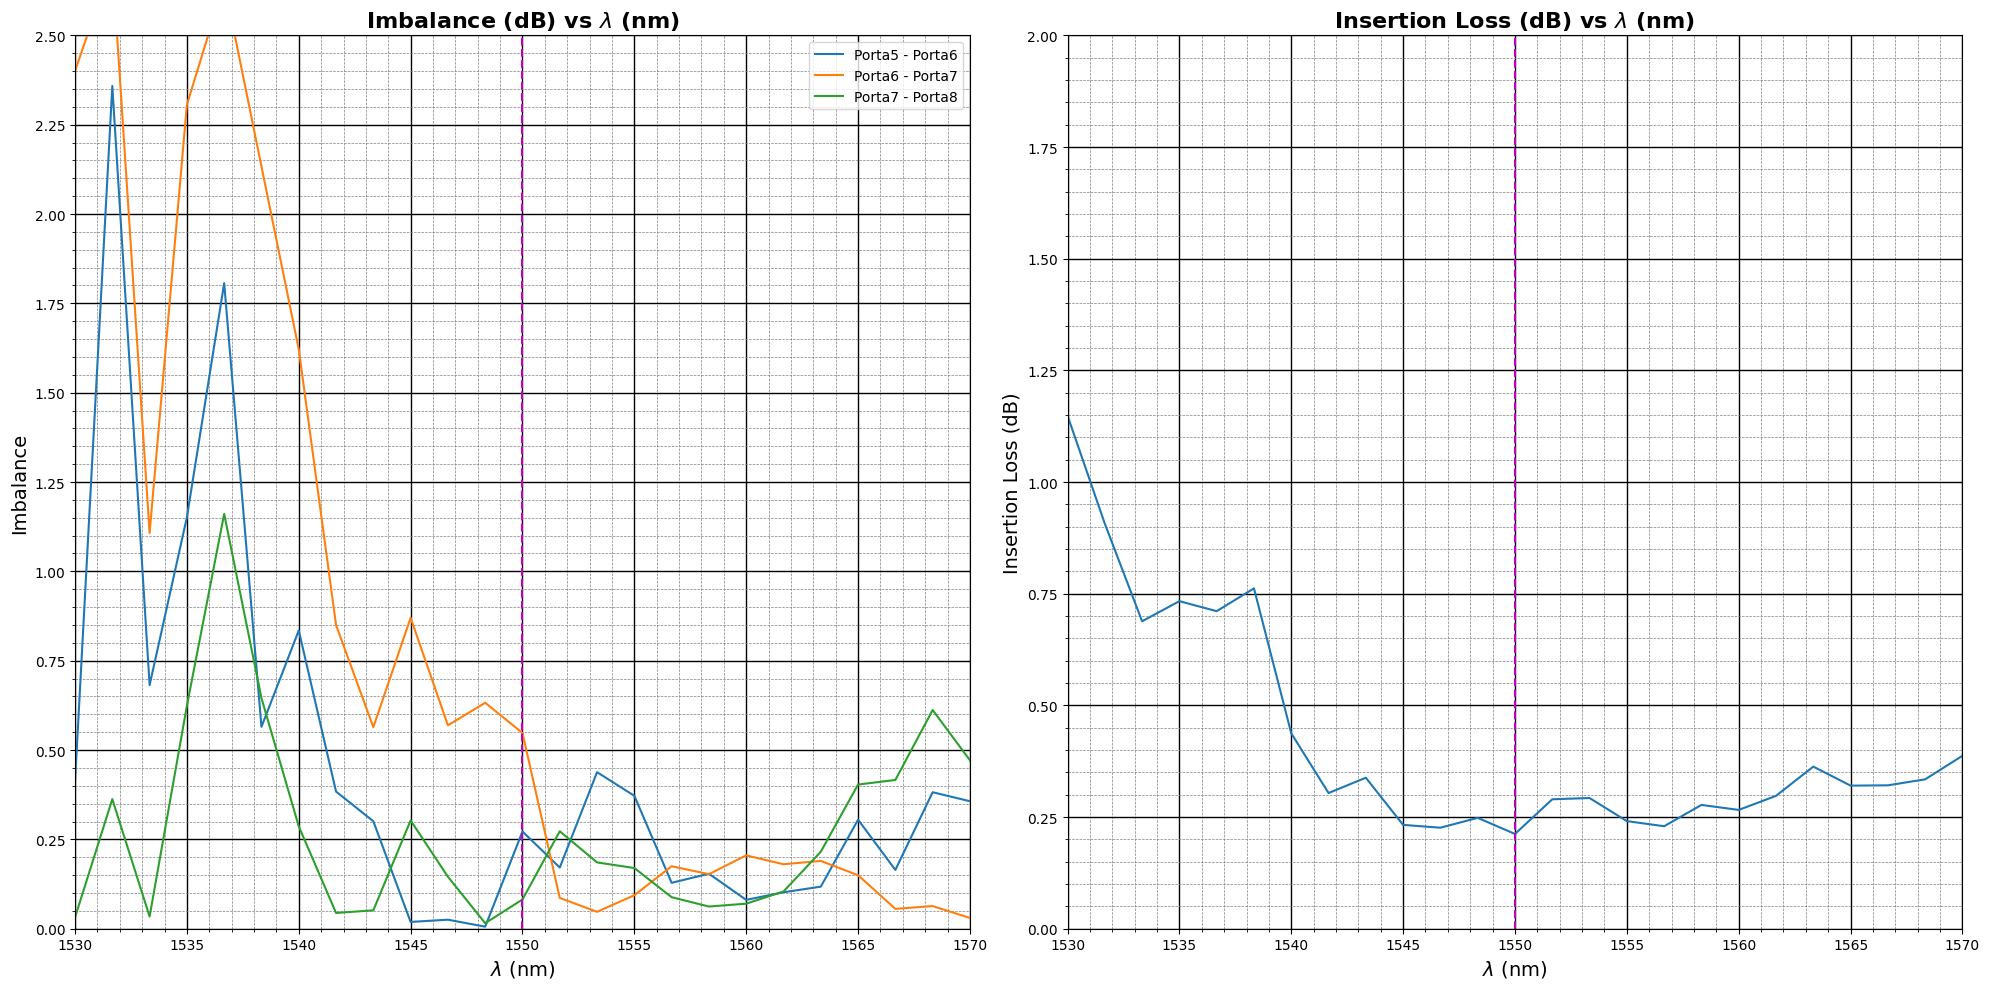

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

Ib1 = np.abs(T5_dB - T6_dB)
Ib2 = np.abs(T6_dB - T7_dB)
Ib3 = np.abs(T7_dB - T8_dB)
axs[0].plot(Lambda, Ib1, lw=1.5, label='Porta5 - Porta6')
axs[0].plot(Lambda, Ib2, lw=1.5, label='Porta6 - Porta7')
axs[0].plot(Lambda, Ib3, lw=1.5, label='Porta7 - Porta8')
axs[0].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[0].set_ylabel('Imbalance', fontsize=14)
axs[0].set_title(r'Imbalance (dB) vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold')
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[0].legend()
axs[0].set_xlim([1530,1570])
axs[0].set_ylim([0,2.5])
axs[0].set_yticks(np.arange(0, 2.6, 0.25))

Il = -10*np.log10(T5 + T6 + T7 + T8)
axs[1].plot(Lambda, Il, lw=1.5)
axs[1].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[1].set_ylabel('Insertion Loss (dB)', fontsize=14)
axs[1].set_title(r'Insertion Loss (dB) vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold')
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[1].set_xlim([1530,1570])
axs[1].set_ylim([0,2])
axs[1].set_yticks(np.arange(0, 2.1, 0.25))


plt.tight_layout()
plt.savefig('Imbalance_e_Perda_de_Insercao_nas_portas_EME_NEW.png')
plt.show()

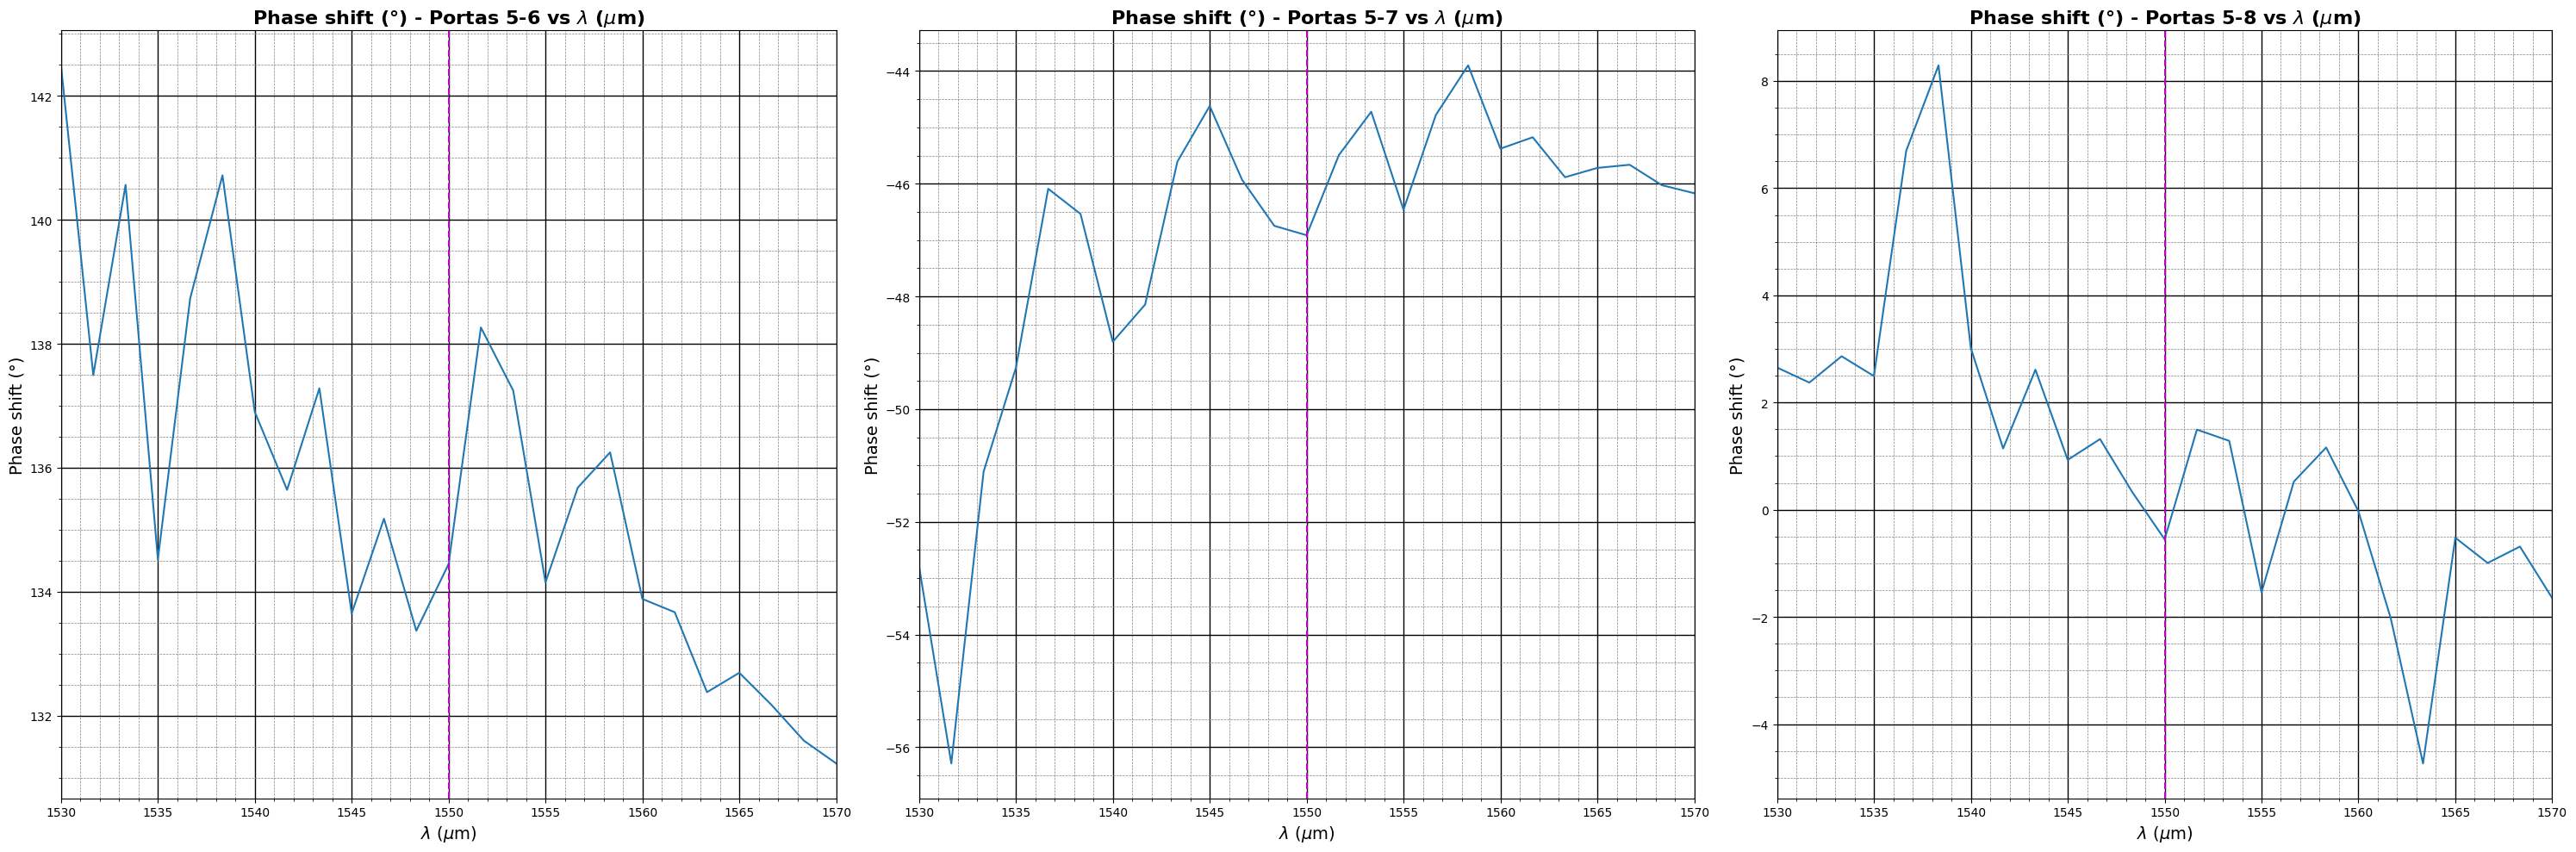

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

phi1 = np.angle(S['s51'])
phi2 = np.angle(S['s61'])
phi3 = np.angle(S['s71'])
phi4 = np.angle(S['s81'])

phase = (phi1 - phi2) * (180 / np.pi)

len_phase = len(phase)

for p in range(len_phase):
    if phase[p] > 180:
        phase[p] = phase[p] - 360
    if phase[p] < -180:
        phase[p] = phase[p] + 360

axs[0].plot(Lambda, phase, lw=1.5)
axs[0].set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=14)
axs[0].set_ylabel("Phase shift (°)", fontsize=14)
axs[0].set_title(r"Phase shift (°) - Portas 5-6 vs $\lambda$ ($\mu$m)", fontsize=16, fontweight = 'bold')
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[0].set_xlim([1530,1570])

phase = (phi1 - phi3) * (180 / np.pi)

for p in range(len_phase):
    if phase[p] > 180:
        phase[p] = phase[p] - 360
    if phase[p] < -180:
        phase[p] = phase[p] + 360

axs[1].plot(Lambda, phase, lw=1.5)
axs[1].set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=14)
axs[1].set_ylabel("Phase shift (°)", fontsize=14)
axs[1].set_title(r"Phase shift (°) - Portas 5-7 vs $\lambda$ ($\mu$m)", fontsize=16, fontweight = 'bold')
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[1].set_xlim([1530,1570])

phase = (phi1 - phi4) * (180 / np.pi)

for p in range(len_phase):
    if phase[p] > 180:
        phase[p] = phase[p] - 360
    if phase[p] < -180:
        phase[p] = phase[p] + 360

axs[2].plot(Lambda, phase, lw=1.5)
axs[2].set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=14)
axs[2].set_ylabel("Phase shift (°)", fontsize=14)
axs[2].set_title(r"Phase shift (°) - Portas 5-8 vs $\lambda$ ($\mu$m)", fontsize=16, fontweight = 'bold')
axs[2].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[2].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[2].minorticks_on()
axs[2].axvline(x=lmbd/nm, color='m', linestyle='--')
axs[2].set_xlim([1530,1570])

plt.tight_layout()
plt.savefig('Fase_nas_portas_EME_NEW.png')
plt.show()

In [60]:
ng = 4.5335
FSR = 1.1*nm
d_L = lmbd**2/(ng*FSR)
L2 = 5*d_L
L1 = L2 - d_L

print(f'\u0394L = {d_L/um:.2f}\u03BCm\nComprimento maior = {L2/um:.2f}\u03BCm\nComprimento menor = {L1/um:.2f}\u03BCm')

ΔL = 481.77μm
Comprimento maior = 2408.84μm
Comprimento menor = 1927.07μm


In [61]:
file_path = r"G:\Outros computadores\Meu laptop - Pessoal\Engenharia Eletrica\Projeto\Adolfo\Projeto final\INTERCONNECT\Interconect_Signal_Noramlized_EME.txt"

porta_5_data = []
porta_6_data = []
porta_7_data = []
porta_8_data = []

current_port = None

with open(file_path, 'r') as file:
    for line in file:
        if 'Porta5' in line:
            current_port = 'Porta5'
            continue
        elif 'Porta6' in line:
            current_port = 'Porta6'
            continue
        elif 'Porta7' in line:
            current_port = 'Porta7'
            continue
        elif 'Porta8' in line:
            current_port = 'Porta8'
            continue

        try:
            wavelength, signal = map(float, line.strip().split(','))
            if current_port == 'Porta5':
                porta_5_data.append((wavelength, signal))
            elif current_port == 'Porta6':
                porta_6_data.append((wavelength, signal))
            elif current_port == 'Porta7':
                porta_7_data.append((wavelength, signal))
            elif current_port == 'Porta8':
                porta_8_data.append((wavelength, signal))
        except ValueError:
            continue


signal_5 = pd.DataFrame(porta_5_data, columns=['wavelength', 'signal'])
signal_6 = pd.DataFrame(porta_6_data, columns=['wavelength', 'signal'])
signal_7 = pd.DataFrame(porta_7_data, columns=['wavelength', 'signal'])
signal_8 = pd.DataFrame(porta_8_data, columns=['wavelength', 'signal'])

Lambda = signal_5['wavelength']

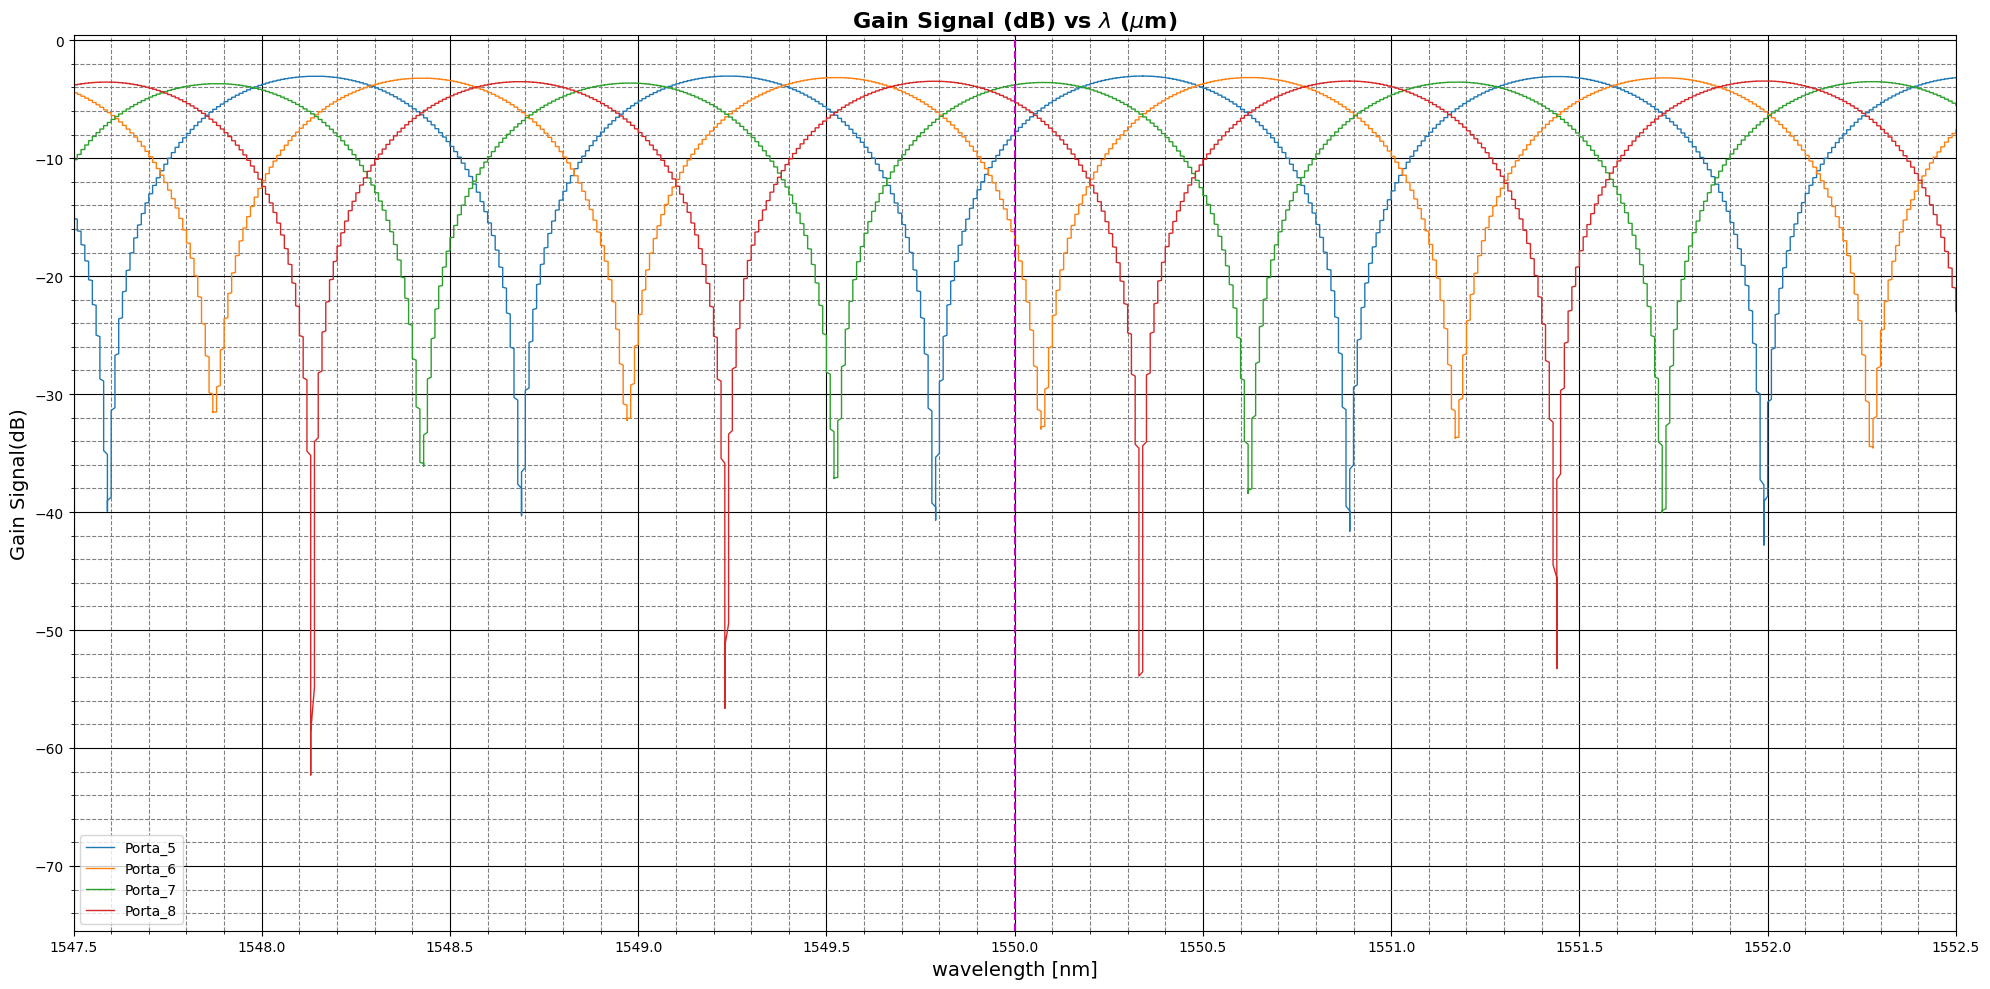

In [62]:
valor_lambda = 1550

plt.figure(figsize=(20, 10))

plt.plot(Lambda, signal_5['signal'], label='Porta_5', linewidth=1)
plt.plot(Lambda, signal_6['signal'], label='Porta_6', linewidth=1)
plt.plot(Lambda, signal_7['signal'], label='Porta_7', linewidth=1)
plt.plot(Lambda, signal_8['signal'], label='Porta_8', linewidth=1)
plt.axvline(x=valor_lambda, color='m', linestyle='--')
plt.xlabel(r'wavelength [nm]', fontsize=14)
plt.ylabel('Gain Signal(dB)', fontsize=14)
plt.title(r'Gain Signal (dB) vs $\lambda$ ($\mu$m)', fontsize=16, fontweight = 'bold',)
plt.legend()
plt.xticks(np.arange(1530, 1570, 0.5))
plt.xlim([1547.5, 1552.5])
plt.grid(which='major', color='black', linestyle='-')
plt.grid(which='minor', color='gray', linestyle='--')
plt.minorticks_on()

plt.tight_layout()
plt.savefig('Signal_Gain_FSR_EME_NEW.png')
plt.show()

In [63]:
file_path = r"G:\Outros computadores\Meu laptop - Pessoal\Engenharia Eletrica\Projeto\Adolfo\Projeto final\INTERCONNECT\Interconect_FSR_EME.txt"

porta_5_data = []
porta_6_data = []
porta_7_data = []
porta_8_data = []

current_port = None

with open(file_path, 'r') as file:
    for line in file:
        if 'Porta5' in line:
            current_port = 'Porta5'
            continue
        elif 'Porta6' in line:
            current_port = 'Porta6'
            continue
        elif 'Porta7' in line:
            current_port = 'Porta7'
            continue
        elif 'Porta8' in line:
            current_port = 'Porta8'
            continue

        try:
            wavelength, phase = map(float, line.strip().split(','))
            if current_port == 'Porta5':
                porta_5_data.append((wavelength, phase))
            elif current_port == 'Porta6':
                porta_6_data.append((wavelength, phase))
            elif current_port == 'Porta7':
                porta_7_data.append((wavelength, phase))
            elif current_port == 'Porta8':
                porta_8_data.append((wavelength, phase))
        except ValueError:
            continue

d_phi = np.pi/2
d_lmbd = d_phi*FSR/(2*np.pi)

print(f'A diferença de comprmento de onda entre os vales de uma porta para outra para garantir \u0394\u03C6 = 90° é \u0394\u03BB = {d_lmbd/nm:.3f}nm')

phase_5 = pd.DataFrame(porta_5_data, columns=['wavelength', 'phase'])
phase_6 = pd.DataFrame(porta_6_data, columns=['wavelength', 'phase'])
phase_7 = pd.DataFrame(porta_7_data, columns=['wavelength', 'phase'])
phase_8 = pd.DataFrame(porta_8_data, columns=['wavelength', 'phase'])

d_phase5 = 0*((2*np.pi*d_lmbd)/phase_5['phase'])*(180/np.pi)
d_phase6 = 1*((2*np.pi*d_lmbd)/phase_6['phase'])*(180/np.pi)
d_phase7 = 2*((2*np.pi*d_lmbd)/phase_7['phase'])*(180/np.pi)
d_phase8 = 3*((2*np.pi*d_lmbd)/phase_8['phase'])*(180/np.pi)

A diferença de comprmento de onda entre os vales de uma porta para outra para garantir Δφ = 90° é Δλ = 0.275nm


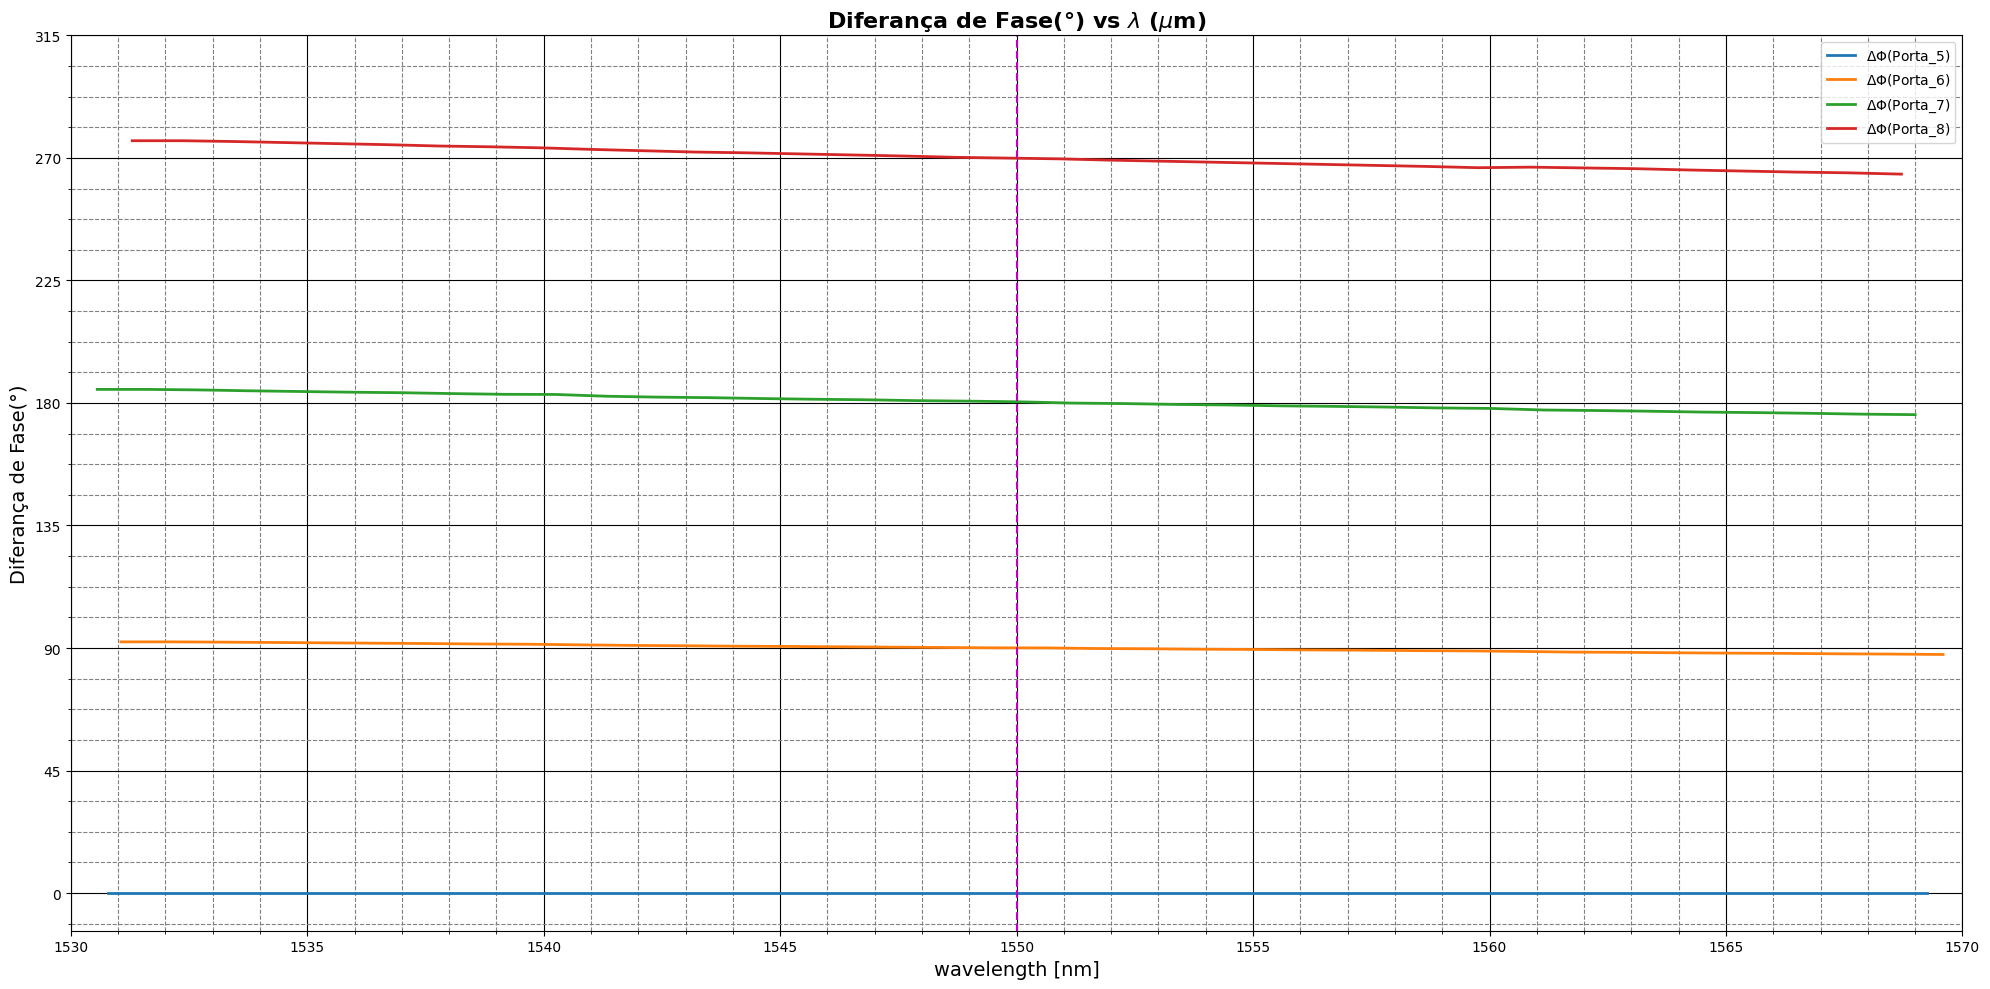

In [64]:
valor_lambda = 1550
plt.figure(figsize=(20, 10))

plt.plot(phase_5['wavelength'], d_phase5, label=r'$\Delta\Phi$(Porta_5)', linewidth=2)
plt.plot(phase_6['wavelength'], d_phase6, label=r'$\Delta\Phi$(Porta_6)', linewidth=2)
plt.plot(phase_7['wavelength'], d_phase7, label=r'$\Delta\Phi$(Porta_7)', linewidth=2)
plt.plot(phase_8['wavelength'], d_phase8, label=r'$\Delta\Phi$(Porta_8)', linewidth=2)
plt.axvline(x=valor_lambda, color='m', linestyle='--')
plt.xlabel(r'wavelength [nm]', fontsize=14)
plt.ylabel('Diferança de Fase(°)', fontsize=14)
plt.title(r'Diferança de Fase(°) vs $\lambda$ ($\mu$m)', fontsize=16, fontweight = 'bold',)
plt.yticks(np.arange(0, 360, 45))
plt.xlim([1530,1570])
plt.legend()
plt.grid(which='major', color='black', linestyle='-')
plt.grid(which='minor', color='gray', linestyle='--')
plt.minorticks_on()

plt.tight_layout()
plt.savefig('Diferença_de_Fase_FSR_EME_NEW.png')
plt.show()

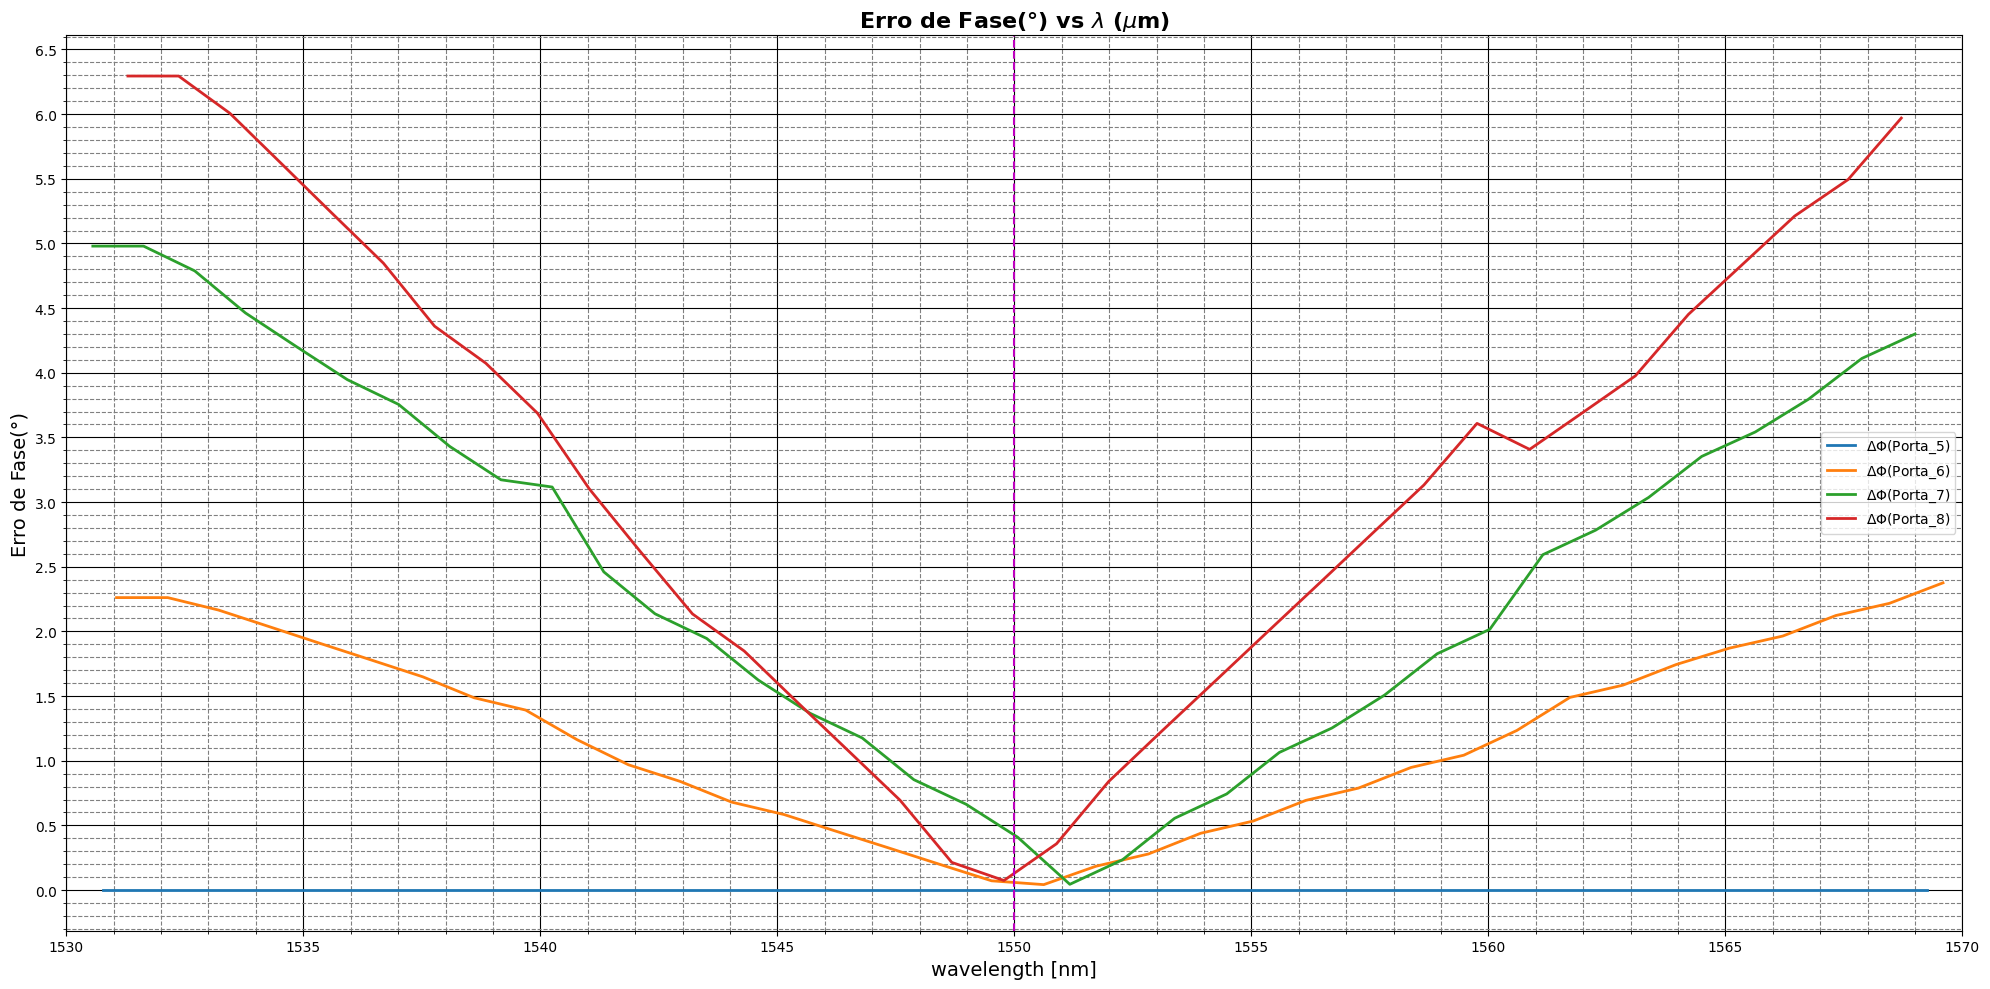

In [65]:
valor_lambda = 1550
d_lmbd = (lmbd_stop - lmbd_start)
plt.figure(figsize=(20, 10))

erro0 = np.full(len(phase_5['wavelength']),0)
erro90 = np.full(len(phase_6['wavelength']),90)
erro180 = np.full(len(phase_7['wavelength']),180)
erro270 = np.full(len(phase_8['wavelength']),270)

erro_phase5 = np.abs(d_phase5 - erro0)
erro_phase6 = np.abs(d_phase6 - erro90)
erro_phase7 = np.abs(d_phase7 - erro180)
erro_phase8 = np.abs(d_phase8 - erro270)

plt.plot(phase_5['wavelength'], erro_phase5, label=r'$\Delta\Phi$(Porta_5)', linewidth=2)
plt.plot(phase_6['wavelength'], erro_phase6, label=r'$\Delta\Phi$(Porta_6)', linewidth=2)
plt.plot(phase_7['wavelength'], erro_phase7, label=r'$\Delta\Phi$(Porta_7)', linewidth=2)
plt.plot(phase_8['wavelength'], erro_phase8, label=r'$\Delta\Phi$(Porta_8)', linewidth=2)
plt.axvline(x=valor_lambda, color='m', linestyle='--')
plt.xlabel(r'wavelength [nm]', fontsize=14)
plt.ylabel('Erro de Fase(°)', fontsize=14)
plt.title(r'Erro de Fase(°) vs $\lambda$ ($\mu$m)', fontsize=16, fontweight = 'bold',)
plt.yticks(np.arange(0, 7, 0.5))
plt.xlim([1530,1570])
plt.legend()
plt.grid(which='major', color='black', linestyle='-')
plt.grid(which='minor', color='gray', linestyle='--')
plt.minorticks_on()

plt.tight_layout()
plt.savefig('Erro_de_Fase_FSR_EME_NEW.png')
plt.show()